# Introduction

- Instroduction about SNAPShot
- The process of genotype calling
- Vary each run time
- Benefit of cloud base system

Star-allele calling from genotyping results is crucial for PGx implementation in
clinical practice. Additionally, a laboratory-developed test (LDT) panel for PGx
implementation is also critical and cost-effective for a specific population; however,
the star-alleles calling tools for the panel need to be developed. In this work,
therefore, we developed a star-allele calling tool applied for the developed testing
panel. The tool also was integrated into the system and website application.

Taken all into consideration, we develop a cloud base system that support user can call genotype and matching with our knowledge database.


# Methods

## Loading FSA data

Raw data from fragment analysis sofware were loaded using package Biopython (version) package. The intensisty data were stored in different predefined chanel name such as DATA105 for refrernce chanel, for other chanels defined for 4 nucleotites (DATA1: A; DATA2:C; DATA3:G and DATA4:T). Those intensisty data were primary used in peak detection process.

## Reference peak detection

As mentioned aboved, the DATA105 chanel as refrence intensity was used to detect the reference peak. Usually, the information of reference peak depends on the experimen desgin. In this study, we used ??? GeneScan 120 Lize dye size standard (CYP2D6 kit developed by SPMED Co. Ltd. (GTR link)). 

We used peak finding function of scipy (version) with default height 800, width of peak, ... However, the setting information can be adjusted by experties.

The number of detected peaks should be equal to number of reference size standard. In case of LIZ 120, there are 9 reference sizes, therefore the number of peaks should be 9 peaks corresponding with the reference size. Only qualifed peak detection was used to develop Least Square model as the next step, otherwise, it need to be adjusted by user to detect the correct reference peaks.

## Sizing model development

As described in the manual of gene mapper software, there were three method to interfer length of DNA based on intensity points (Local Southern, Global Southern and Least Square). In the work, we used Least Square as advance method to develop a model for sizing identification (Ref).

The model was developed using numpy (version) python package. Users can choose the order of least sequare method (second-order or third-order). The performance of this model was evaluated using R square index from actual size and precited size. Based on R square, we found that third-order resulted in a slightly higher than second order, therefore, thrid order was set as default of the model. The model development process will be done by each input FSA file.

## Peak detection of raw data

As mentioned before, raw data includes 4 chanels (DATA1, DATA2, DATA3, DATA4). Each chanel theorically defines for a nucleotite. The nucleotide can be change base on primer design in forward or reverse trand of the DNA.
The data chanel for peak detection process was selected based on which base and which the direction of the primer (Table). The direction of each marker was preloaded following kit information. (???Kit information, certificate)


## Star allele calling


## Performance validation

We validated our software using XXX sample including XXX cell lines and XXX real sample.
To compare the performance of the tools with experts, the only intensity plot of those sample were randomly distribute to 2 PGx experts. All other information of those sample were hidden. The manual calling result from two experts then gathered and compared. if any miss-matched between result of two persons, we invited the third expert to decided the genotype of this sample. The consuming time was also recorded.
The final call obtained by experts were compared with our tool's calling results.


Workflow


Please see here: https://app.diagrams.net/#G1HzMMyRkVhr8Y_M1wMmXwmZagIEpak1Bb

In [1]:
from Bio import SeqIO
from sklearn.metrics import r2_score
from scipy.signal import find_peaks, peak_prominences, peak_widths
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')


def loadFSA(aFSA):
    """Load FSA file
    Args:
        aFSA (str): A path to a FSA file.

    Returns:
        SeqIO: A data loaded from FSA file.
    """

    return(SeqIO.read(aFSA, 'abi'))



def generateReferenceRange(reference):
    """Generate all range from reference data

    Args:
        reference (list, required): A list contain all bp locations of refernces.
                                    Defaults to [15, 20, 25, 35, 50, 62, 80, 110, 120].

    Returns:
        list:   The list contant all generated range of the references
                Example: [(15, 20), (20,25)]
    """

    referenceRange = []
    
    for i,_ in enumerate(reference):
        if i < len(reference)-1:
            referenceRange.append((reference[i], reference[i+1]))

    return referenceRange



def getRawData(FSA, chanel):
    """Extract raw intensity by chanel.

    Args:
        FSA (class): A class load FSA file.
        chanel (str): An interested intensity chanel.

    Returns:
        Tuple: A tuple about a chanel intensity data.
    """
    return FSA.rawdata[chanel]



class FSA:
    def __init__(self, aFSA) -> None:
        self.data = SeqIO.read(aFSA, 'abi')
        self.name = self.data.name
        self.id = self.data.id
        self.description = self.data.description
        self.rawdata = self.data.annotations['abif_raw']

    def panel(self):
        """Extract panel from fsa name. The first element of the name was consider as the panel.

        Returns:
            str: name of the panel
        """
        return self.name.split('-')[0]
    
    @property
    def reference_intensity(self):
        """Extract reference intensity, in the fsa raw data format, DATA105 is defined for reference intensity chanel.

        Returns:
            tupe: A tupe of all reference intensity data.
        """
        return self.rawdata['DATA105']
    
    @property
    def chanel_size(self):
        """Return chanel size, it will be used for generate number of points and make basepairs prediction.

        Returns:
            int: Length of the intensity chanel.
        """
        return len(self.reference_intensity)

    def extract_intensity(self, chanel, range=None):
        """Extract the intensity by a specific chanel.
           In the FSA file, there 4 chanels (DATA1, DATA2, DATA3, DATA4) following 4 nucleotides (ATCG)

        Args:
            chanel (str): chanel name for [DATA1, DATA2, DATA3, DATA4]
            range (tupe, optional): A tupe defines an intersted range for extract. It was resulted in by `get_index_by_base_range` function. Defaults to None.

        Returns:
            tupe: intensity of the selected chanel
        """
        if range:
            return self.rawdata[chanel][range[0]:range[1]]
        else:
            return self.rawdata[chanel]


    @property
    def sample_name(self):
        return extract_sample_name(self.name)

class Reference:
    def __init__(self, aRef) -> None:
        self.size = aRef
        self.range = generateReferenceRange(self.size)
        self.length = len(self.size)



# def finding_peaks(intensity, min_width=None, min_height=800, min_prominence = None, distance = None):
#     """Finding Peaks based on intensity data

#     Args:
#         intensity (tupe, required): intensity data from a chanel
#         min_width (int, optional): threshold minimum width of the peaks. Defaults to None. Reference value: 1
#         min_height (int, optional): threshold minimum height of the peaks. Defaults to 500.
#         min_prominence (int, optional): threshold minimum depth of the peaks. Defaults to None. Reference value 50

#     Returns:
#         peaks: a list of detected peaks
#         heights: a list of corresponding detected peaks
#     """
    
#     peaks, heights = find_peaks(intensity, height=min_height, distance=distance)
#     heights = heights['peak_heights']

#     if min_prominence:
#         prominence = peak_prominences(intensity, peaks)
#         conditions =  np.where(prominence[0] >= min_prominence)
#         peaks = peaks[conditions]
#         heights = heights[conditions]
    
#     if min_width:
#         width = peak_widths(intensity, peaks)
#         conditions = np.where(width[0] >= min_width)
#         peaks = peaks[conditions]
#         heights = heights[conditions]

#     return peaks, heights


def finding_peaks(intentisty, expected_size = 9, height=300, distance='auto', prominences='auto'):

    peaks, heights = find_peaks(intentisty, height=height)

    if len(peaks) > expected_size:
        # print('adjust prominences')
        
        if prominences == 'auto':
            pro = peak_prominences(intentisty, peaks)[0]
            pro_sort = np.sort(pro)[::-1]
            m_pro = pro_sort[expected_size]
            peaks, heights = find_peaks(intentisty, height=height, prominence=m_pro+0.001)

            # print(pro)
        else:
            peaks, heights = find_peaks(intentisty, 
                                        height=height,
                                        prominence=prominences)
    
    if len(peaks) > expected_size:
        if distance == 'auto':
            diff = np.sort(np.diff(peaks))[::-1]
            m_dist = diff[expected_size-1]
            peaks, heights = find_peaks(intentisty, height=height, distance=m_dist+0.001)
        else:
            peaks, heights = find_peaks(intentisty, 
                                        height=height,
                                        distance=distance)

    return peaks, heights['peak_heights']



class LeastSquared:

    """Building a LeastSequared model to predict the size of DNA based on intensity data points.
       Each fsa can be different each run, therefore, model will be build based on specific data from FSA and reference.

       The method of model was refer from gene mapper reference. More information can be found here:
        Sizing: https://www2.unbc.ca/sites/default/files/sections/genetics/microsat.pdf
        Peak scanner:  https://apps.thermofisher.com/apps/peak-scanner/help/GUID-CEE18138-6788-48FA-8E08-4CE939F4B9D8.html

    """
    
   
    
    def __init__(self, peak, reference_size, degree = 3):
        self.peak = peak
        self.reference_size = reference_size
        self.degree = degree
        self.popt = np.polyfit(self.peak, self.reference_size, self.degree)
        self.ref_predicted = np.polyval(self.popt, self.peak)
        # self.ref_predicted = np.round(self.ref_predicted, 2)


    @property
    def r2_score(self):
        return r2_score(self.reference_size, self.ref_predicted)

    def val_plot(self, title=None):
        """Plot a validation figure from reference and predicted result.

        Args:
            title (str): Title of the figure, it can be a fsa name.
        """
        _min = np.min(self.peak) - 100
        _max = np.max(self.peak) + 100
        xn = range(_min, _max +1)
        yn = np.polyval(self.popt, xn)
        
        fig, ax = plt.subplots(figsize=(5,3), dpi = 150)
        alpha = 0.8
        ax.plot(xn, yn, color = 'blue', label = 'Predicted', alpha = alpha)
        ax.plot(self.peak, self.reference_size, 'or', label = 'Reference', alpha =alpha)
        
        for peak, size in zip(self.peak, self.reference_size):
            ax.text(peak, size + 4, f'{size}', fontsize =6, ha='center')

        ax.set_xlabel('Points')
        ax.set_ylabel('Size (bp)')
        if title:
            ax.set_title(title, fontsize = 8)

        fig.text(0.2, 0.80, f'$R^{2} = {str(self.r2_score)}$')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    def predict(self, x):
        """Predict basepairs based on range of points

        Args:
            x (list): A list of points want to be predicted by built model

        Returns:
            np.array: An array includes predicted basepairs.
        """
        return np.round(np.polyval(self.popt, x),2)

    def fit(self, x:list):
        """predicted base bairs

        Args:
            x (list): data points
        """
        self.predicted_base = self.predict(x)



class Allele:
    def __init__(self, base:str, basetype:str, is_forward:bool, min_bin:int, max_bin:int, min_height:int = 500) -> None:
        """Create allele class

        Args:
            base (str): tested nucleotide [A,T,C,G]
            basetype (str): whether base is wildtype or mutant
            min_bin (int): min bin set for peak detection
            max_bin (int): max bin set for peak detection
            min_height (int, optional): min height for peak detection. Defaults to 500.
        """
        self.base = base
        self.basetype = basetype
        self.min_bin = min_bin
        self.max_bin = max_bin
        self.min_height = min_height
        self.is_forward = is_forward
    
    @property
    def color(self):
        """Return color based on marker's direction and target base

        Returns:
            str: color
        """
        return forward_color.get(self.base) if self.is_forward else reverse_color.get(self.base)

    @property
    def data_chanel(self):
        """Return data chanel based on marker's direction and target base

        Returns:
            _type_: _description_
        """
        return data_chanel_map.get(self.base) if self.is_forward else data_chanel_map.get(reverse_map.get(self.base))



# define the color of forward
forward_color = {
    'Ref': 'orange',
    'A': 'green',
    'T': 'red',
    'C': 'black',
    'G': 'blue'
    }

# define the color of reverse
reverse_color = {
    'Ref': 'orange',
    'A': 'red',
    'T': 'green',
    'C': 'blue',
    'G': 'black'
}

# define data chanel
data_chanel_map = {
    'Ref': 'DATA105',
    'G':'DATA1',
    'A':'DATA2',
    'C':'DATA3',
    'T':'DATA4'
}

# revese complementation of base.
reverse_map = {
    'A':'T',
    'T':'A',
    'G':'C',
    'C':'G'
}


class Marker:

    def __init__(self, gene:str, marker_name: str, marker_label:str, panel:str, is_forward:bool, alleles = []) -> None:
        """Creat a marker class

        Args:
            gene (str): gene name
            marker_name (str): marker name
            marker_label (str): marker label
            panel (str): panel name, it should be identical with chanel detected from FSA file
            is_forward (bool): direction of this marker, True mean forward, False mean reverse.
            alleles (list, optional): Allele class information. Defaults to [].
        """
        self.gene = gene
        self.marker_name = marker_name
        self.marker_label = marker_label
        self.is_forward = is_forward
        self.alleles = alleles
        self.panel = panel
        self.direction = 'Forward' if self.is_forward else 'Reverse'
        # self.num_alleles = 0
    
    def add_allele(self, allele):

        """Update allele to the list of allele in this marker.
            It also update the direction of the marker to this allele.
        """
        allele.is_forward = self.is_forward
        self.alleles.append(allele)
    
    @property
    def num_alleles(self):
        return len(self.alleles)

    def update_allele_config(self, allele_number:int, min_bin:int=None, max_bin:int=None, min_height:int=None):
        """update allele configuration to adjust the bin size and height to call the peaks

        Args:
            allele_number (int): number of allele in the marker. It ussually can be 0,1 since each marker often have 2 alleles, but somes may have more than 2.
            min_bin (int, optional): Min bin size for this allele. Defaults to None.
            max_bin (int, optional): Max bin sizx for this allele. Defaults to None.
            min_height (int, optional): Min height for this allele. Defaults to None.
        """
        allele = self.alleles[allele_number]

        if min_bin:
            allele.min_bin = min_bin

        if max_bin:
            allele.max_bin = max_bin

        if min_height:
            allele.min_height = min_height

        self.alleles[allele_number] = allele


def get_index_by_base_range(base_pred, base_ranges=(0,200)):
    """Get index of orginal intensity based on intested basepairs.


    Args:
        base_pred (_type_): _description_
        ranges (tuple, optional): _description_. Defaults to (0,200).

    Returns:
        _type_: _description_
    """
    min_index = np.where(base_pred >= base_ranges[0])[0][0]
    max_index = np.where(base_pred >= base_ranges[1])[0][0]

    return (min_index, max_index)


def plot_raw_intensity(fsa,min_index, max_index, select_base, base_range=(20,80)):
    fig, ax = plt.subplots(1,1, figsize =(12,3), dpi = 200)
    ax.set_xlim(*base_range)
    for base in data_chanel_map:
        chanel = data_chanel_map.get(base)
        intensity = fsa.extract_intensity(chanel, (min_index, max_index))
        color = forward_color.get(base)
        alpha = 0.6 if base == 'Ref' else 1

        ax.plot(select_base, intensity, color = color, label = chanel, alpha = alpha)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def generate_markers(peak_table):

    maker_list = {}
    for _,row in peak_table.iterrows():
        m = Marker(row.gene, row.marker, row.marker_label, row.panel, row.is_forward, [])
        
        m.define_colors = {row.w_base:row.w_color, row.m_base:row.m_color}

        a1 = Allele(row.w_base, 'wildtype', row.is_forward, row.w_min, row.w_max, row.w_height)
        # a1.set_color(row.is_forward)
        a2 = Allele(row.m_base, 'mutant', row.is_forward, row.m_min, row.m_max, row.m_height)
        # a2.set_color(row.is_forward)
        m.add_allele(a1)
        m.add_allele(a2)
        maker_list[m.marker_name] = m

    return maker_list


def finding_peak_by_markers(markers:dict, fsa:FSA, panel:str, select_base:list, index_range:tuple):
    """Finding peak by marker dictionary and update the called result to the marker dictionary

    Args:
        markers (dict): A dictionary of markers that includes defined information to call a peak such as bin size, height, data chanel and base 
        fsa (FSA): FSA data loaded from fsa file
        panel (str): Panel definition, it should be match with panel defined in the file name, need to be discussed with PGx to make consensus naming convention.
        select_base (list): a list of predicted basepair from model, it was used to match with bin size and data points.
        index_range (tuple): index data point to extract intensity data
    """

    for marker_name in markers:
        marker = markers.get(marker_name)
        marker.sample_name = fsa.sample_name
        if marker.panel == panel:
            for i,allele in enumerate(marker.alleles):
                intensity = fsa.extract_intensity(allele.data_chanel, (index_range[0],index_range[1]))
                _min = np.where(select_base >= allele.min_bin)[0][0]
                _max = np.where(select_base <= allele.max_bin)[0][-1]
                i_base = select_base[_min:_max]
                i_intensity = intensity[_min:_max]
                # peak,height = finding_peaks(i_intensity, 
                #                             min_height= allele.min_height, 
                #                             min_width=0.7, 
                #                             min_prominence=30,
                #                             distance=0.30*(_max - _min))

                peak, height = finding_peaks(i_intensity,
                                             expected_size =1,
                                             height=allele.min_height)
                
                # print(f'{marker_name}:{peak}')

                if peak.size == 1:
                    allele.is_detected = True
                    allele.peak = peak
                    allele.size = i_base[peak]
                    allele.height = height
                    allele.status = 'ok'
                    allele.message = ''
                elif peak.size > 1:
                    allele.is_detected = True
                    allele.peak = peak
                    allele.size = i_base[peak]
                    allele.height = height
                    allele.status = 'warning'
                    allele.message = 'More than 1 peaks detected!'
                else:
                    allele.is_detected = False
                    allele.peak = ''
                    allele.size = ''
                    allele.height = ''
                    allele.status = ''
                    allele.message = 'Peak(s) could not be detected. Please check peak ranges if required!'
                
                # print('append allele', marker.marker_name)
                marker.alleles[i] = allele

            markers[marker_name] = marker

    # update genotype 
    update_marker_genotype(markers, panel)

    return markers


def update_marker_genotype(markers:dict, panel:str):
    """Update the genotype of each marker based on the peak calling process.

    Args:
        markers (dict): a dictionary of a called marker
        panel (str): panel
    """
    for marker_name in markers:
        marker = markers.get(marker_name)
        if marker.panel == panel:
            genotype = ''
            phenotype = ''
            is_called = False
            basetype = []
            called_base = []
            for j, allele in enumerate(marker.alleles):
                if allele.status == 'ok':
                    called_base.append(allele.base)
                    basetype.append(allele.basetype)
            
            if len(called_base) == 1:
                genotype = f'{called_base[0]}{called_base[0]}'
                is_called = True
            elif len(called_base) == 2:
                genotype = f'{called_base[0]}{called_base[1]}'
                is_called = True
            
            if len(set(basetype)) == 1:
                if basetype[0] == 'wildtype':
                    phenotype = 'wildtype'
                else:
                    phenotype = 'homozygous mutant'
            elif len(set(basetype)) == 2 and len(basetype) == 2:
                phenotype = 'heterozygous'

            marker.genotype = genotype
            marker.is_called = is_called
            marker.phenotype = phenotype

            markers[marker_name] = marker


# def print_marker(markers):
#     status = False
#     for marker_name in markers:
#         marker = markers.get(marker_name)
#         if hasattr(marker, 'is_called'):
#             status = marker.is_called
#             print(marker.marker_name, marker.panel, status, marker.genotype, marker.phenotype)
#         else:
#             print(marker.marker_name, marker.panel)


# def load_snapshot_file(snapshot_file):
#     df = pd.read_csv(snapshot_file, sep='\t').fillna("")
#     df['Allele 2'] = np.where(df['Allele 2'] == "", df['Allele 1'], df['Allele 2'])
#     df["Genotype"] = df['Allele 1'] + df["Allele 2"]
#     df['Gene'] = [x[0] for x in df['Marker'].str.split("_")]
#     df['ExtractedSample'] = [extract_sample_name(x) for x in df['Sample Name']]
#     df['SampleStatus'] = [is_valid_sample_name(x) for x in df['Sample Name']]

#     df = df[['Sample File', 'Sample Name', 'ExtractedSample', 'SampleStatus', 'Panel',
#              'Gene', 'Marker', 'Genotype', 'Allele 1', 'Allele 2']]
#     return df


# def is_valid_sample_name(sample_name, p='_S[0-9]+'):
#     pattern = re.compile(p)
#     if pattern.search(sample_name):
#         return True
#     else:
#         return False


# def format_call_markers(markers):
#     df = pd.DataFrame()
#     for marker_name in markers:
#         marker = markers.get(marker_name)
#         for allele in marker.alleles:
#             tmp = pd.DataFrame(allele.__dict__, index=[0])
#             tmp['color'] = allele.color
#             tmp['sample'] = marker.sample_name
#             tmp['gene'] = marker.gene
#             tmp['marker'] = marker.marker_name
#             tmp['panel'] = marker.panel
#             tmp['direction'] = 'Forward' if marker.is_forward else 'Reverse'
#             tmp['genotype'] = marker.genotype
#             tmp['phenotype'] = marker.phenotype
#             df = pd.concat([df, tmp])

#     ## marker table
#     marker_table = (df[df.columns[-7:]].drop_duplicates()).reset_index(drop=True)

#     # allele table
#     cols = df.columns[:-2]
#     cols = cols[-5:].tolist() + cols[:-5].tolist() 
#     allele_table = df[cols].reset_index(drop=True)

#     return marker_table, allele_table
        

# def extract_sample_name(sample_name, p='_S[0-9]+'):
#     pattern = re.compile(p)
#     if pattern.search(sample_name):
#         return pattern.split(sample_name)[0]
#     else:
#         # print(f'{sample_name} is not valid! Keep as origin')
#         return sample_name


# def extract_sample_name(fsa_name:str, pattern = '[0-9]+-[0-9]+_'):

#     """Extract sample name from fsa file name. It can be applied for bin text file as well.
#        But we need to define the file name convention with PGx team to have rule to extract the sample name.

#     Returns:
#         str: sample name extracted from file name
#     """
#     p = re.compile(pattern)
#     s = p.search(fsa_name)
    
#     return s.group(0).replace('_', '')


def extract_sample_name(fsa_name:str, pattern = '-S|_S'):

    """Extract sample name from fsa file name. It can be applied for bin text file as well.
       But we need to define the file name convention with PGx team to have rule to extract the sample name.

    Returns:
        str: sample name extracted from file name
    """
    p = re.split(pattern, fsa_name)
    # s = p.search(fsa_name)
    
    return p[0]


class GenotypeResult:
    
    def __init__(self) -> None:
        self.is_from_file = False

    def from_bin_file(self, bin_file:str, marker_info:dict):
        """Since our result can be obtained from calling FSA file or from bin text file. This function is to process data from bin text file

        Args:
            bin_file (str): bin text file obtained from gene mappeer
            marker_info (dict): Information of the defined marker includes color, direction, label and other infomration.
        """

        self.file = bin_file
        self.raw_data = pd.read_csv(bin_file, sep='\t').fillna('')
        self.is_from_file = True
        self.clean_data = self._clean_from_bin_data(marker_info)
        self.process_star_5()
        self.sample_list = self.clean_data['sample'].unique().tolist()
        # self.marker_table = self._marker_table

    def from_fsa_call(self, called_markers:dict):
        """Process result called from FSA file

        Args:
            called_markers (dict): marker includes the peaking calling information
        """
        self.is_from_file = False
        self.raw_data = called_markers
        
        clean_data = pd.DataFrame()
        for marker_name in called_markers:
            marker = called_markers.get(marker_name)
            for allele in marker.alleles:
                # print(allele.__dict__)
                tmp = pd.DataFrame(allele.__dict__, index=[0])
                # tmp = pd.DataFrame(allele.__dict__, index=range(0,lengt))
                tmp['color'] = allele.color
                tmp['sample'] = marker.sample_name
                tmp['gene'] = marker.gene
                tmp['marker'] = marker.marker_name
                tmp['label'] = marker.marker_label
                tmp['panel'] = marker.panel
                tmp['direction'] = 'Forward' if marker.is_forward else 'Reverse'
                tmp['genotype'] = marker.genotype
                tmp['phenotype'] = marker.phenotype
                
                clean_data = pd.concat([clean_data, tmp])         
        
        self.clean_data = clean_data.reset_index(drop=True)
        self.sample_list = self.clean_data['sample'].unique().tolist()
        self.process_star_5()

    def process_star_5(self):
        
        # process marker CYP2D6_010 (*5)
        """
        if heterozygous of *5 was detected, it will not automatically update the homozygous genotype of other alleles.
        For example: keep G instead of GG as normal case
        """
        star_5_marker = 'CYP2D6_010' #it need to be changed if the number of maker changes
        star_5_genotype = self.clean_data[self.clean_data['marker'] == star_5_marker]['genotype'].unique()[0]
        
        def update_genotype(marker, genotype):
            if marker != star_5_marker:
                return list(set(genotype))[0]
            else:
                return genotype

        if len(set(star_5_genotype)) == 2:
            self.clean_data['genotype'] = self.clean_data.apply(lambda row: update_genotype(row['marker'], row['genotype']), axis=1)


    

    def _clean_from_bin_data(self, marker_info:dict):
        """Detail function to process data from bin text file

        Args:
            marker_info (dict): Information of the defined marker includes color, direction, label and other infomration.

        Returns:
            DataFrame: an updated data frame
        """
        
        if self.is_from_file:
            cols = ['Sample File', 'Sample Name', 'Marker', 'Panel', 'Allele 1', 'Allele 2',
                    'Size 1', 'Size 2', 'Height 1', 'Height 2']
            m_cols = ['sample_file', 'sample_name', 'marker', 'panel', 'base1', 'base2',
                    'size1', 'size2', 'height1', 'height2']
            df = self.raw_data[cols]
            df.columns = m_cols
            
            # extract gene, panel and sample
            df['gene'] = df.marker.apply(lambda x: x.split('_')[0])
            df['panel'] = df.panel.apply(lambda x: x.split('-')[1])
            df['sample'] = df['sample_name'].apply(lambda x: '-'.join(x.split('-')[1:]))

            # generate genotype
            df['genotype'] = df.apply(lambda row: row['base1'] + row['base1'] if row['base2'] == '' else row['base1'] + row['base2'], axis=1)

            # update phenotype

            def _get_type_base(marker):
                wildtype_base = []
                mutant_base = []
                for allele in marker.alleles:
                    if allele.basetype == 'wildtype':
                        wildtype_base.append(allele.base)
                    else:
                        mutant_base.append(allele.base)

                return wildtype_base, mutant_base


            def _update_phenotype(marker_name, genotype):
                marker = marker_info.get(marker_name)
                wildtype, mutant = _get_type_base(marker)
                _genotype = pd.Series(list(set(genotype)))

                if len(_genotype) == 1:
                    if all(_genotype.isin(wildtype)):
                        return 'wildtype'
                    else:
                        return 'homozygous mutant'
                elif len(_genotype) ==  2:
                    if all(_genotype.isin(mutant)):
                        return 'homozygous mutant'
                    else:
                        return 'heterozygous mutant'
                elif len(_genotype) == 0:
                    return ''
                else:
                    raise ValueError('invaid genotype input!')

             # df['phenotype'] = df.genotype.apply(lambda x: 'homozygous' if x in ['AA', "GG", "CC", "TT"] else 'heterozygous')
            df['phenotype'] = df.apply(lambda row: _update_phenotype(row['marker'], row['genotype']), axis = 1)

            # df['direction'] = '' # we dont know marker inforamtion in this file, need to be updated later

            df = pd.wide_to_long(df, stubnames=['base', 'size', 'height'], 
                                    j='n_bases', i=['marker', 'sample'], sep='')
            df = df.reset_index()

            def _color(marker, base):
                return marker.define_colors.get(base)
            
            # def _direction(marker)

            df['color'] = df.apply(lambda row: _color(marker_info.get(row.marker), row.base), axis = 1)
            df['direction'] = df.apply(lambda row: marker_info.get(row.marker).direction, axis = 1)
            df['label'] = df.apply(lambda row: marker_info.get(row.marker).marker_label, axis = 1)


        return df


    def marker_table(self, sample_name = None):
        """Return a marker data information table

        Args:
            sample_name (str, optional): Filter marker table by sample name if required. Defaults to None.

        Returns:
            DataFrame: marker table
        """

        cols = ['sample', 'gene', 'marker', 'label', 'panel', 'direction', 'genotype', 'phenotype']

        df = self.clean_data[cols].drop_duplicates()

        if sample_name:
            df = df[df['sample'] == sample_name]

        return df

        

    def allele_table(self, sample_name = None, called_filter=True):

        """Return a allele data information table. It can be different from bin file or fsa file.
           Because some information we could not get from bin text file result and fsa file.

        Returns:
            _type_: _description_
        """

        if self.is_from_file:

            cols = ['sample', 'gene', 'marker', 'label', 'panel', 'direction',
                    'base', 'size', 'height', 'color']

        else:
            cols = ['sample', 'gene', 'marker', 'label', 'panel', 'direction',
                    'base', 'basetype',	'min_bin', 'max_bin', 'min_height', 
                    'is_forward', 'is_detected', 'peak', 'size', 'height',
                    'status', 'message', 'color']

        
        df = self.clean_data[cols].drop_duplicates()

        if sample_name:
            df = df[df['sample'] == sample_name]

        if called_filter:
            if self.is_from_file:
                df = df[pd.notna(df.color)] 
            else:
                df = df[df.is_detected] 

        return df

    
    def plotting_qc(self, sample_name:str, showfig=True):
        """Plot QC chromatogram based on called genotype: peak size, peak height.
           It will plot all panel of this sample.

        Args:
            sample_name (str): name of sample
        """
        
        allele_data = self.allele_table(sample_name)

        figs = {}
        for panel in allele_data.panel.unique():
            fig = plot_qc(allele_data[allele_data.panel == panel], title = f'{sample_name}-{panel}', showfig=showfig)
            figs[panel] = fig

        return figs
        

def generate_intensity(size, height):

    '''Generate intensity base on height of each allele'''
    
    # generate width based on height

    _range = 2.5 if height < 4000 else 2.7
        
    width = np.arange(-1*_range,_range,0.01)

    intensity = height*np.exp(-15*np.log(1+(width**2)/10))

    # set 1 first and last intensity = 0 to make sure all all k
    intensity[0] = 0
    intensity[-1] = 0
    
    return width, intensity


def plot_qc(data, xlim =(20,80), 
         figsize =(15,4),
         dpi = 200,
         alpha = 0.8,
         marker_labels=True,
         ex_height = 0.2,
         ex_annotation = 0.05, 
         title=None,
         showfig = False):
    
    data = data.sort_values('height')
    max_height = np.max(data.height)

    plt.ioff()

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.set_xlim(*xlim)
    ax.set_ylim(0, max_height +  max_height * ex_height)
    ax.grid(linestyle='--', alpha = 0.3, color ='gray', linewidth = 0.3)

    if title:
        ax.set_title(title)

    for idx, row in data.iterrows():

        width, y = generate_intensity(row['size'], row.height)

        x = width + row['size']
        # print(row.size)
        
        ax.fill(x, y, color=row.color, alpha=alpha)

    # process marker information
    props = dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.5)
    if marker_labels:
        tmp = data.groupby(['label'], as_index=False).agg({'size':np.average, 'height':np.max})

        for _, row in tmp.iterrows():
            ax.text(row['size'],
                    row.height + max_height * ex_annotation,
                    row.label, 
                    ha='center',
                    fontsize = 11,
                    bbox=props)

    plt.tight_layout()

    if showfig:
        plt.show()

    return fig     



def call_from_fsa(fsa_files:list, target_markers:dict, reference:list, val_plot=True, intensity_plot = True):
    # load reference size
    ref = Reference(reference)

    markers = target_markers.copy()
    # print_marker(markers)
    supports_data = []
    for fsa_file in fsa_files:
        
        fsa = FSA(fsa_file)
        ref_intensity = fsa.reference_intensity
        ref_peaks, ref_heights = finding_peaks(ref_intensity, expected_size=9, height=300)

        # build model
        model = LeastSquared(ref_peaks, ref.size, degree=3)

        if val_plot:
            model.val_plot(fsa.name)

        # predict base from model
        pred = model.predict(range(fsa.chanel_size))

        # extract interested range 0 to 200 bp

        min_index, max_index = get_index_by_base_range(pred, base_ranges=(0,130))

        select_base = pred[min_index:max_index]
        # print(select_base)

        # extract panel
        # fsa_panel = fsa.name.split('-')[0]
        
        ## update extract panel based on real file

        fsa_panel = re.compile("S[0-9]").search(fsa.name).group(0)

        data = dict(fsa=fsa, model=model, 
                    panel=fsa_panel,
                    predicted_base= pred)

        # find peak and update results to markers
        markers = finding_peak_by_markers(markers, fsa, fsa_panel,select_base, (min_index, max_index))

        supports_data.append(data)
    
    genotype = GenotypeResult()
    genotype.from_fsa_call(markers)

    # if intensity_plot:
    #     fig, ax 

    
    return genotype, supports_data


class Definition:
    """This class is to load the tables data from definition file the already processed before.
       There are 3 tables in this tables file and they are interconnecting each other.
       This class will help us to quick extract the information from defintion tables
    """
    def __init__(self, tables) -> None:
        self.tables = tables
        self.gene_table = self.tables['gene_table']
        # self.marker_table = self.tables['marker_table']
        self.genotype_marker_table = self.tables['genotype_marker_table']
        self.marker_table = self._add_gene_to_marker_table()
    

    def extract_geneid(self, gene):
        return self.gene_table[self.gene_table['gene'] == gene]['gene_id']


    def _add_gene_to_marker_table(self):
        return self.tables['marker_table'].merge(self.gene_table, how ='left', on='gene_id')


    def extract_marker(self, gene=None):
        if gene:
            return self.marker_table[self.marker_table['gene'] == gene]
        else:
            return self.marker_table

    
    def get_target_marker(self, gene:str):
        
        df = self.genotype_marker_table
        if gene:
            df = self.genotype_marker_table[self.genotype_marker_table['gene'] == gene]
        
        genotype_id = df['genotype_id'].tolist()[0]
        marker_names = df[df['genotype_id'] == genotype_id]['marker']

        df = df[['gene', 'genotype', 'marker', 'value']].pivot(index='genotype', columns='marker', values='value')
        df = df[marker_names]
        df['target'] = df[marker_names].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

        return {'marker_name':marker_names, 'pattern':df}


# def check_if_marker_called(defined_markers, sample_markers):

#     df = defined_markers.merge(sample_markers, how='left', on='marker', suffixes=('_defined', ''))

#     return df.marker[np.where(pd.isna(df.genotype))[0]]


def generate_sample_pattern(sample_markers, target_marker_names):
    """Generate comparison pattern of sample to compare with patterns from definition tables.clear
       Example: 
       Marker_01    AA
       Marker_02    CT

       Pattern: AA_(CT|TC)


    Args:
        sample_markers (DataFrame): A DataFrame contains all called genotypes
        target_marker_names (list): A list of the target marker name from definition tables

    Returns:
        str: the generated pattern
    """
    df = sample_markers[sample_markers.marker.isin(target_marker_names)]
    cols = ['sample','gene', 'marker', 'genotype'] 
    df = df[cols]

    def _generate_pattern(genotype):

        if genotype not in ['AA', 'GG', 'CC', 'TT']:
            return f'({genotype}|{genotype[::-1]})'
        else:
            return genotype
    
    df['genotype'] = df['genotype'].apply(lambda x: _generate_pattern(x))

    df = df.pivot(index='sample', columns='marker', values='genotype')
    df = df[target_marker_names]
    df['exp_sample'] = df[target_marker_names].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

    return df['exp_sample'][0]


def call_star_allele(sample_pattern, targets):
    """Matching pattern of sample and defintion table

    Args:
        sample_pattern (str): sample pattern
        targets (DataFrame): A data frame includes all generate pattern for all combination star allele (diplotype) from definition table.

    Returns:
        (str):  All called diplotype (star allele combintations) that can match with this sample.
                If more than one matched, the result will be joined and separeted by "|". For example: *1/*2xN|*1xN/*2
    """
    matched = [bool(re.fullmatch(pattern=sample_pattern, string=target))
                       for target in targets['target']]
    genotype = '|'.join(targets.iloc[np.where(matched)].index.values.tolist())

    return genotype


def plot_intensity(genotype_data, support_data, base_range=(10,130)):

    figs = []
    for data in support_data:

        fig = go.Figure()

        for base in data_chanel_map:
            chanel = data_chanel_map.get(base)
            
            if chanel == 'DATA105':
                opacity = 0.2
            else:
                opacity = 1
            
            mi, ma = get_index_by_base_range(data.get('predicted_base'), base_range)
            intensity = data.get('fsa').extract_intensity(chanel, (mi, ma))
            x = data.get('predicted_base')[mi:ma]
            color = forward_color.get(base)
            fig.add_trace(go.Scatter(x= x, y = intensity, mode='lines', 
                                    line_color = color, opacity=opacity, name=chanel))
        allele_table = genotype_data.allele_table()
        allele_table = allele_table[allele_table['panel'] == data.get('panel')]
        
        fig.add_trace(go.Scatter(x =allele_table['size'], y = allele_table['height'], 
                            mode='markers+text', text=allele_table['base'], 
                            name ='Detected Peaks', marker_color = allele_table['color']))

        fig.update_traces(textposition="top center", textfont_color = allele_table['color'])

        fig.update_layout(
            title = f'{data.get("fsa").name}',
            xaxis_title = 'Size (bp)',
            yaxis_title = 'Intensity',
            autosize =False, 
            width = 1500, 
            height = 500
        )

        figs.append(fig)
    return figs
        

## Load defined marker with colors

This form is test form and it was based on the format from PGx team.

However this form have a disavantage if testing allele is not biallelic for example triallelic (A > C/T). and this requires a new format to overcome this issue.


In [2]:
import pandas as pd
peak_table = pd.read_excel('./resource/test_bin_peak.xlsx')
defined_markers = generate_markers(peak_table)

liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]

## Example call from fsa file with CYP2D6 and 2 panels

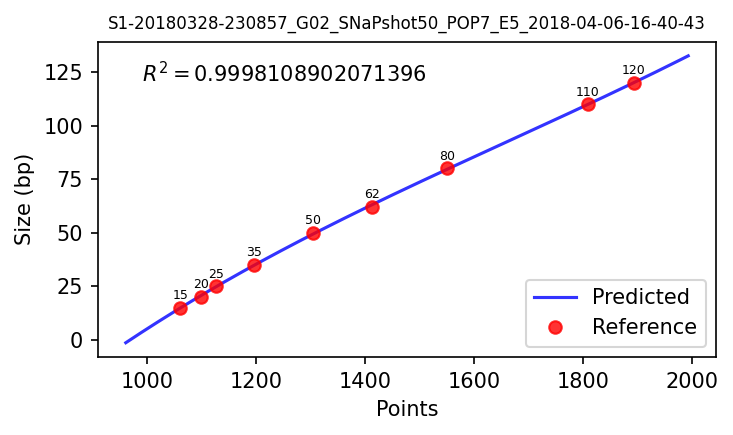

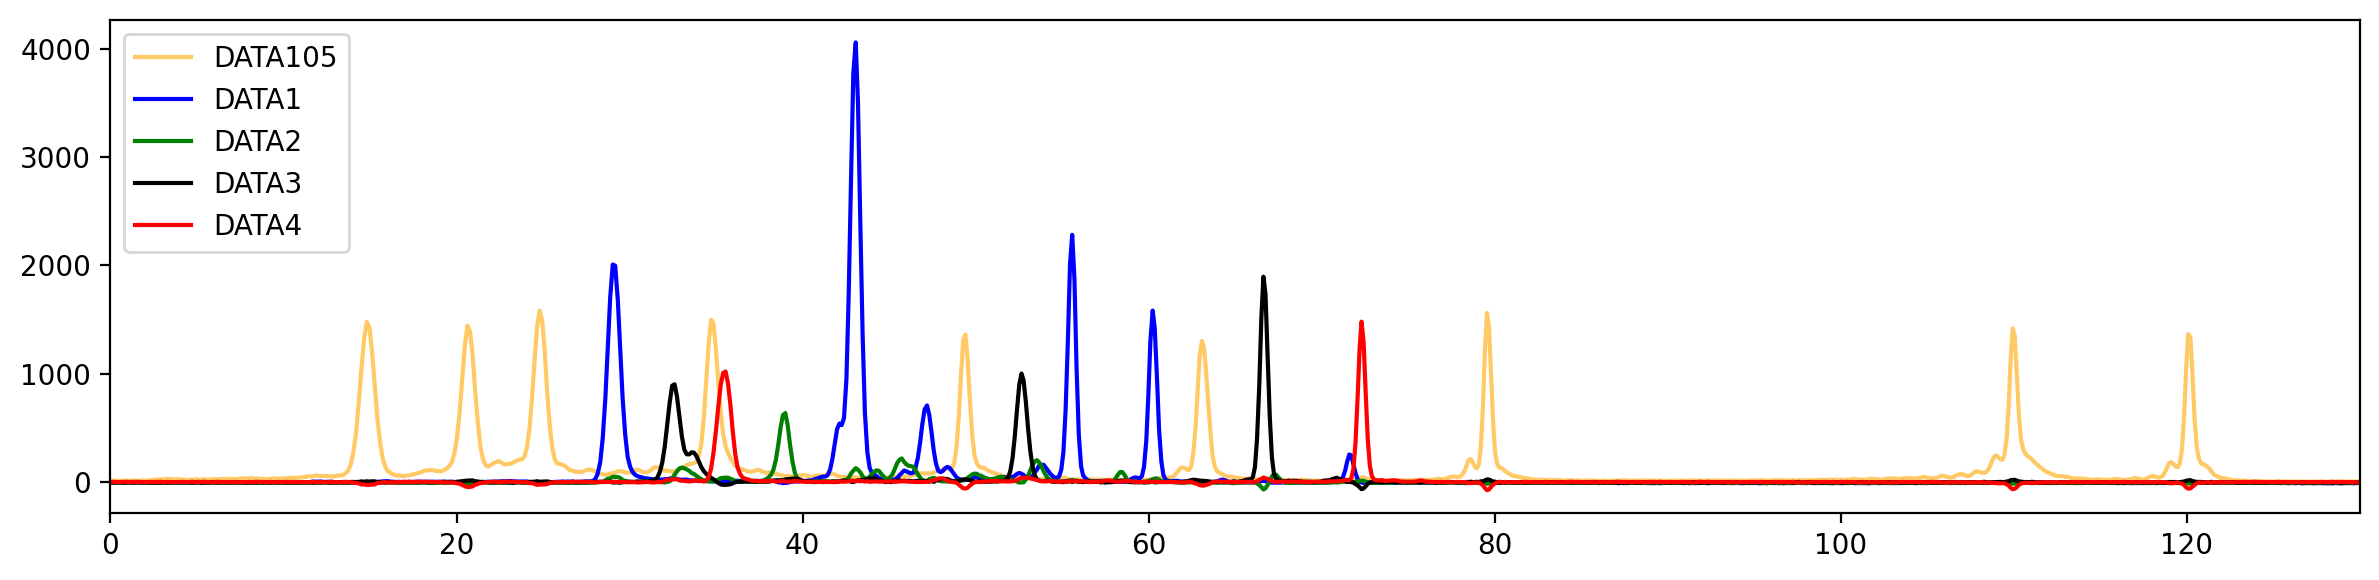

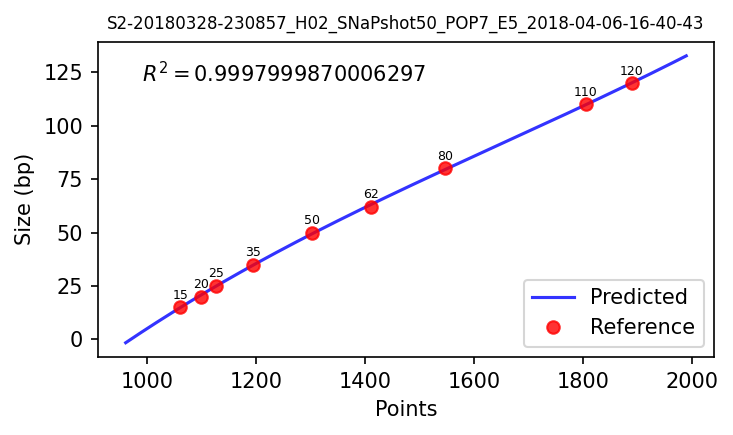

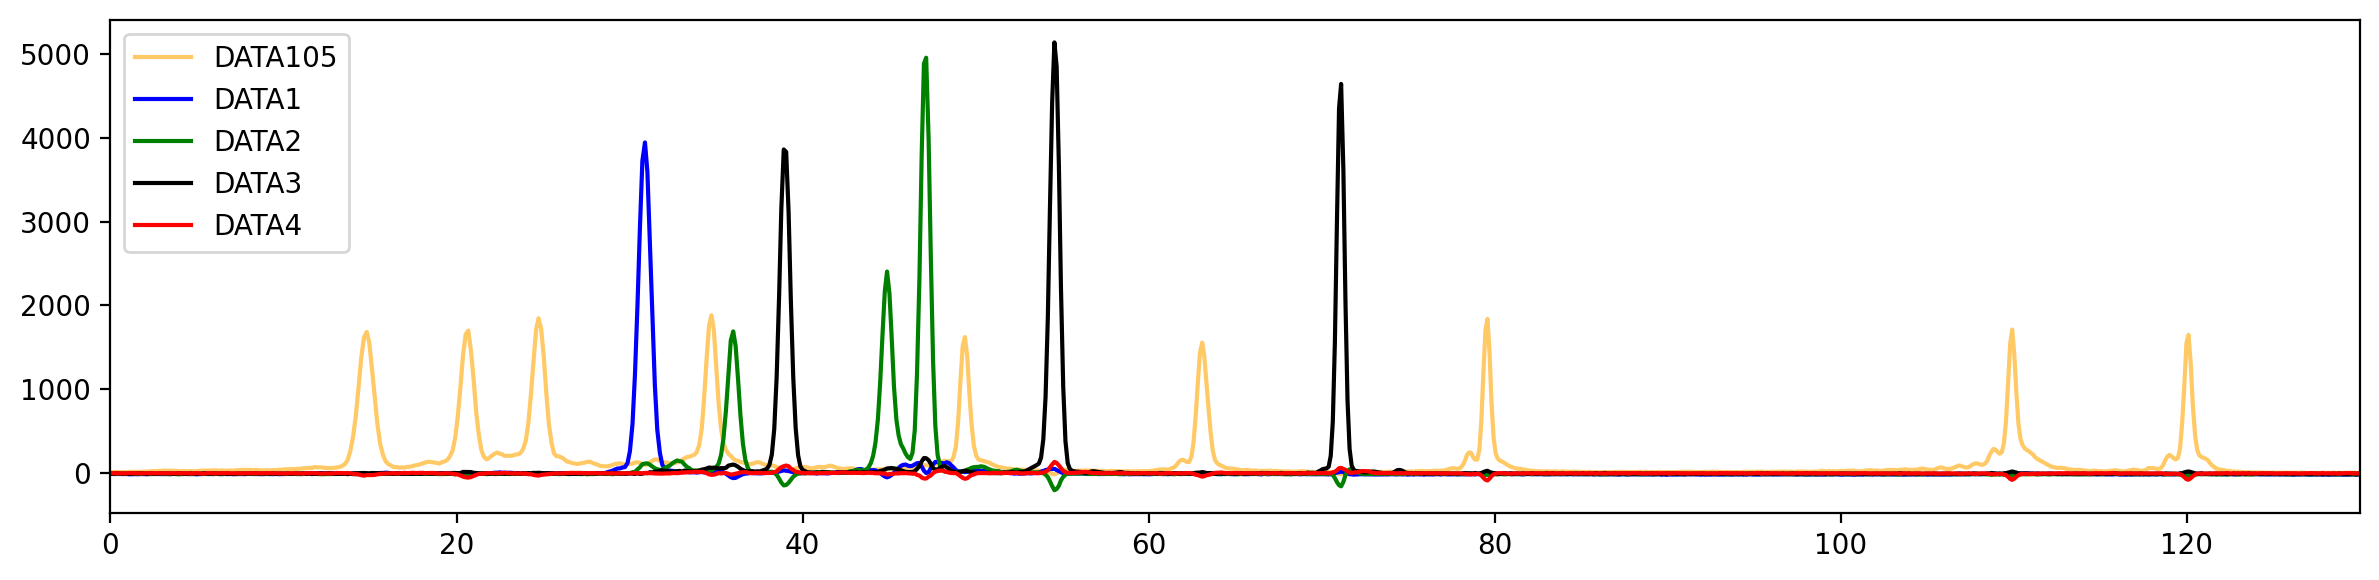

20180328-230857:*1/*10B


In [3]:
fsa_files = ['./raw_data/fsa/PA180404A/S1-20180328-230857_G02_SNaPshot50_POP7_E5_2018-04-06-16-40-43.fsa',
             './raw_data/fsa/PA180404A/S2-20180328-230857_H02_SNaPshot50_POP7_E5_2018-04-06-16-40-43.fsa']
liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]

import pickle
with open('./resource/tables.pdata', 'rb') as t:
    tables = pickle.load(t)

definition = Definition(tables)

#load origin markers
s1 = call_from_fsa(fsa_files, defined_markers, liz120)

# call_from_fsa(fsa_files, defined_markers, liz120)
    # input:
        # 1. fsa_files
        # 2. defined_markers = generate_markers
            # Input: (1): test_bin_peak.xlsx
        # 3. liz120: ref size: e.g.: [15, 20, 25, 35, 50, 62, 80, 110, 120]


# print(s1)

gene = 'CYP2D6'

g = GenotypeResult()
g.from_fsa_call(s1)

for sample in g.sample_list:

    sample_data = g.marker_table(sample)

    targets = definition.get_target_marker(gene)
    sample_pattern = generate_sample_pattern(sample_data, targets['marker_name'])

    result = call_star_allele(sample_pattern, targets['pattern'])
    print(f'{sample}:{result}')


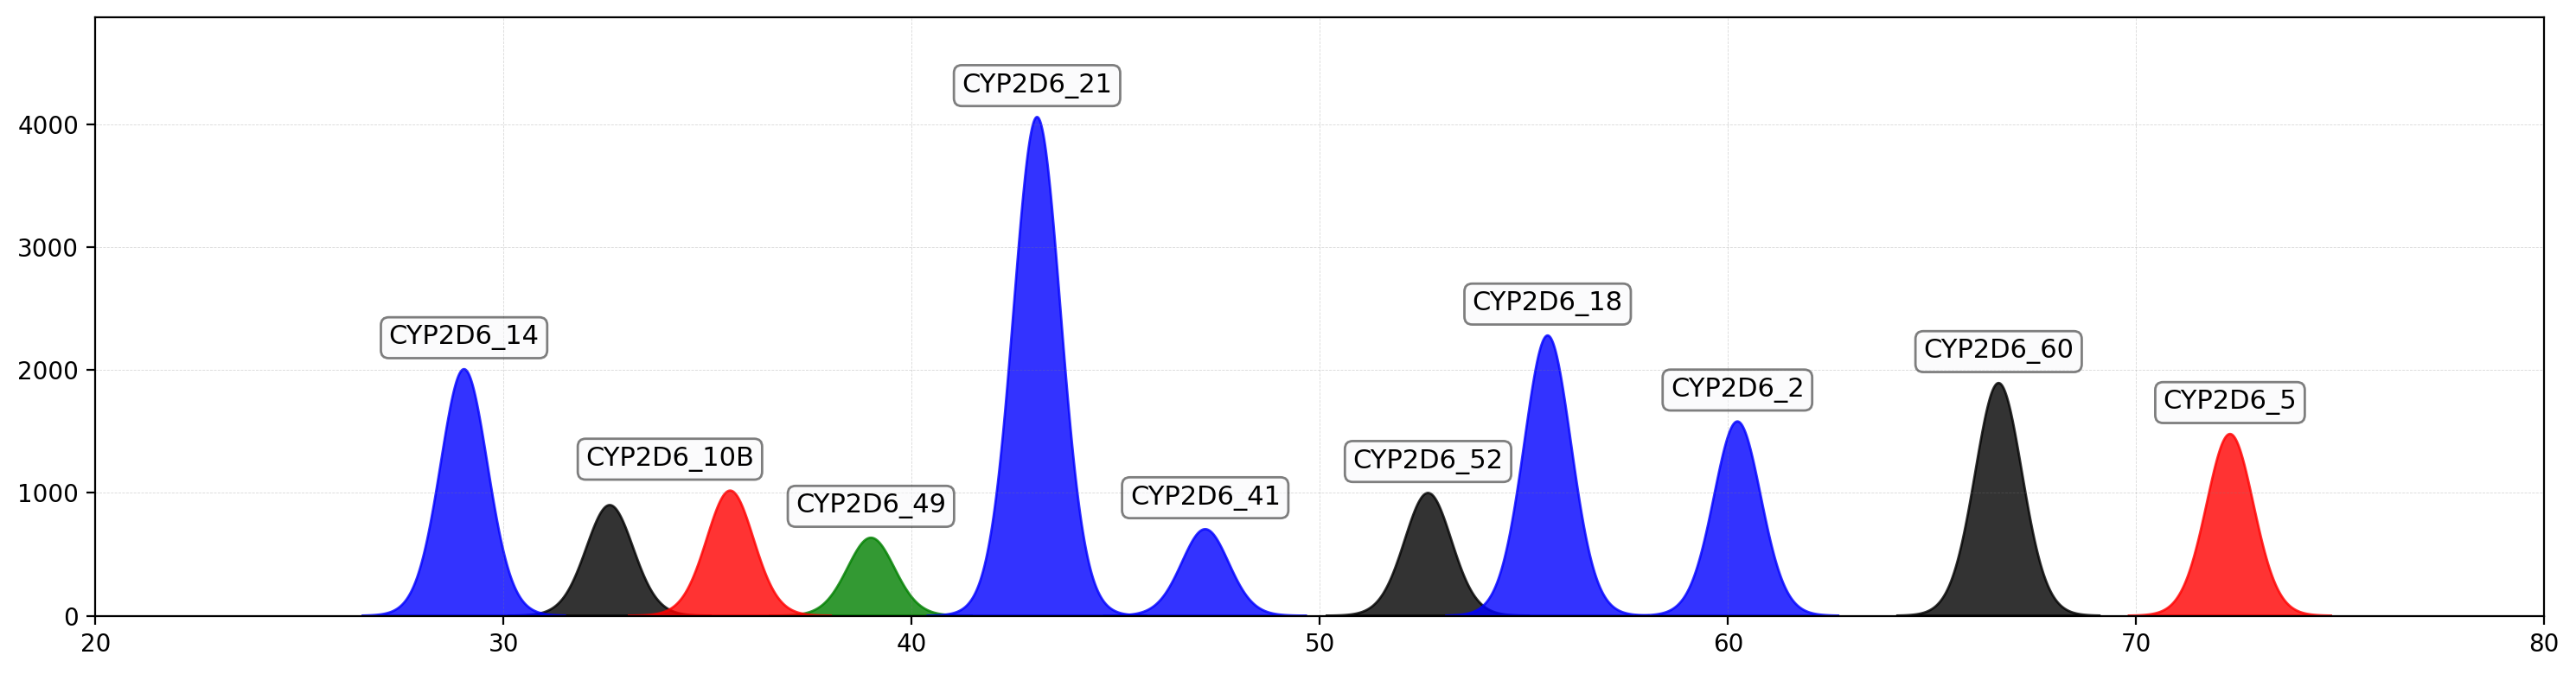

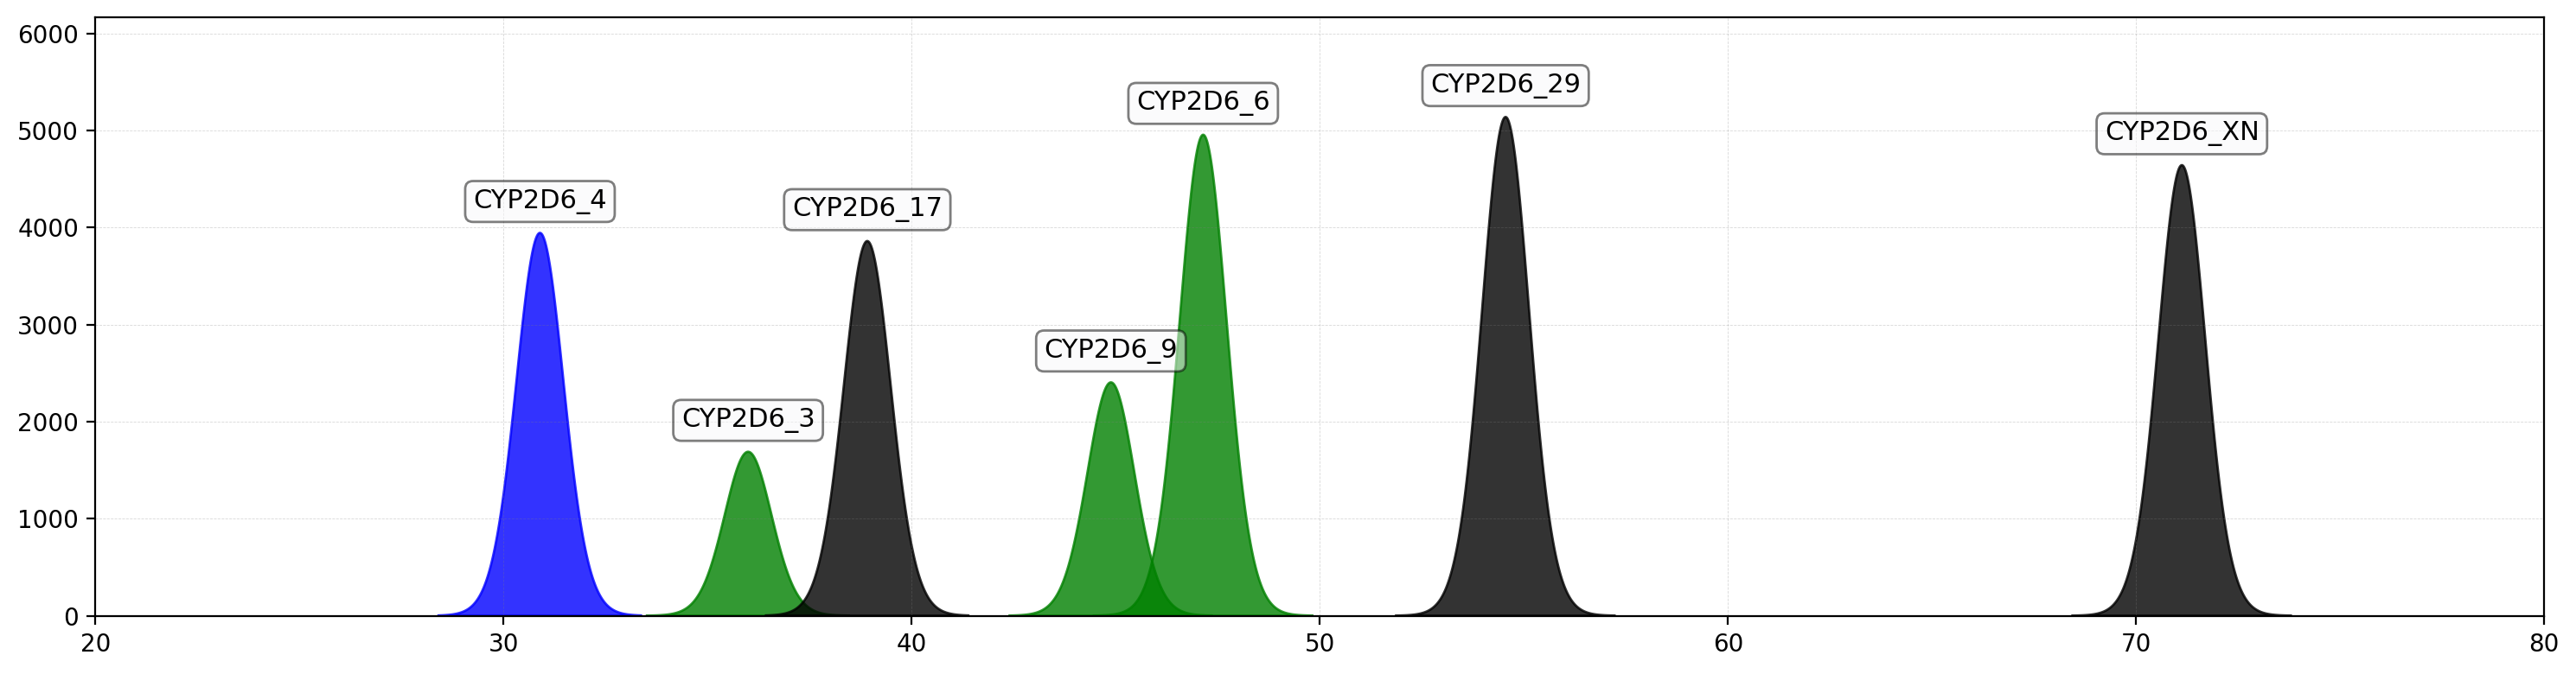

In [4]:
g.plotting_qc('20180328-230857')

## Example call from bin file

In [5]:
g2 = GenotypeResult()
g2.from_bin_file('./raw_data/bin_text/PA180404A_CYP2D6_Example.txt', defined_markers)

gene = 'CYP2D6'

for sample in g2.sample_list:
    sample_data = g2.marker_table(sample)

    # defined_markers = definition.extract_marker(gene)
    targets = definition.get_target_marker(gene)
    sample_pattern = generate_sample_pattern(sample_data, targets['marker_name'])
    
    result = call_star_allele(sample_pattern, targets['pattern'])

    print(f'{sample}:{result}')


20180328-230857:*1/*10B
PTC:*1/*1
NTC:


In [ ]:
g2.marker_table()

In [7]:
g2.marker_table().head(1)

sample    gene      marker      label panel direction genotype  \
0  20180328-230857  CYP2D6  CYP2D6_001  CYP2D6_14    S1   Forward       GG   

  phenotype  
0  wildtype

In [8]:
g2.allele_table(sample_name='20180328-230857', called_filter=True).head(1)

sample    gene      marker      label panel direction base   size  \
0  20180328-230857  CYP2D6  CYP2D6_001  CYP2D6_14    S1   Forward    G  29.04   

   height color  
0  6967.0  blue

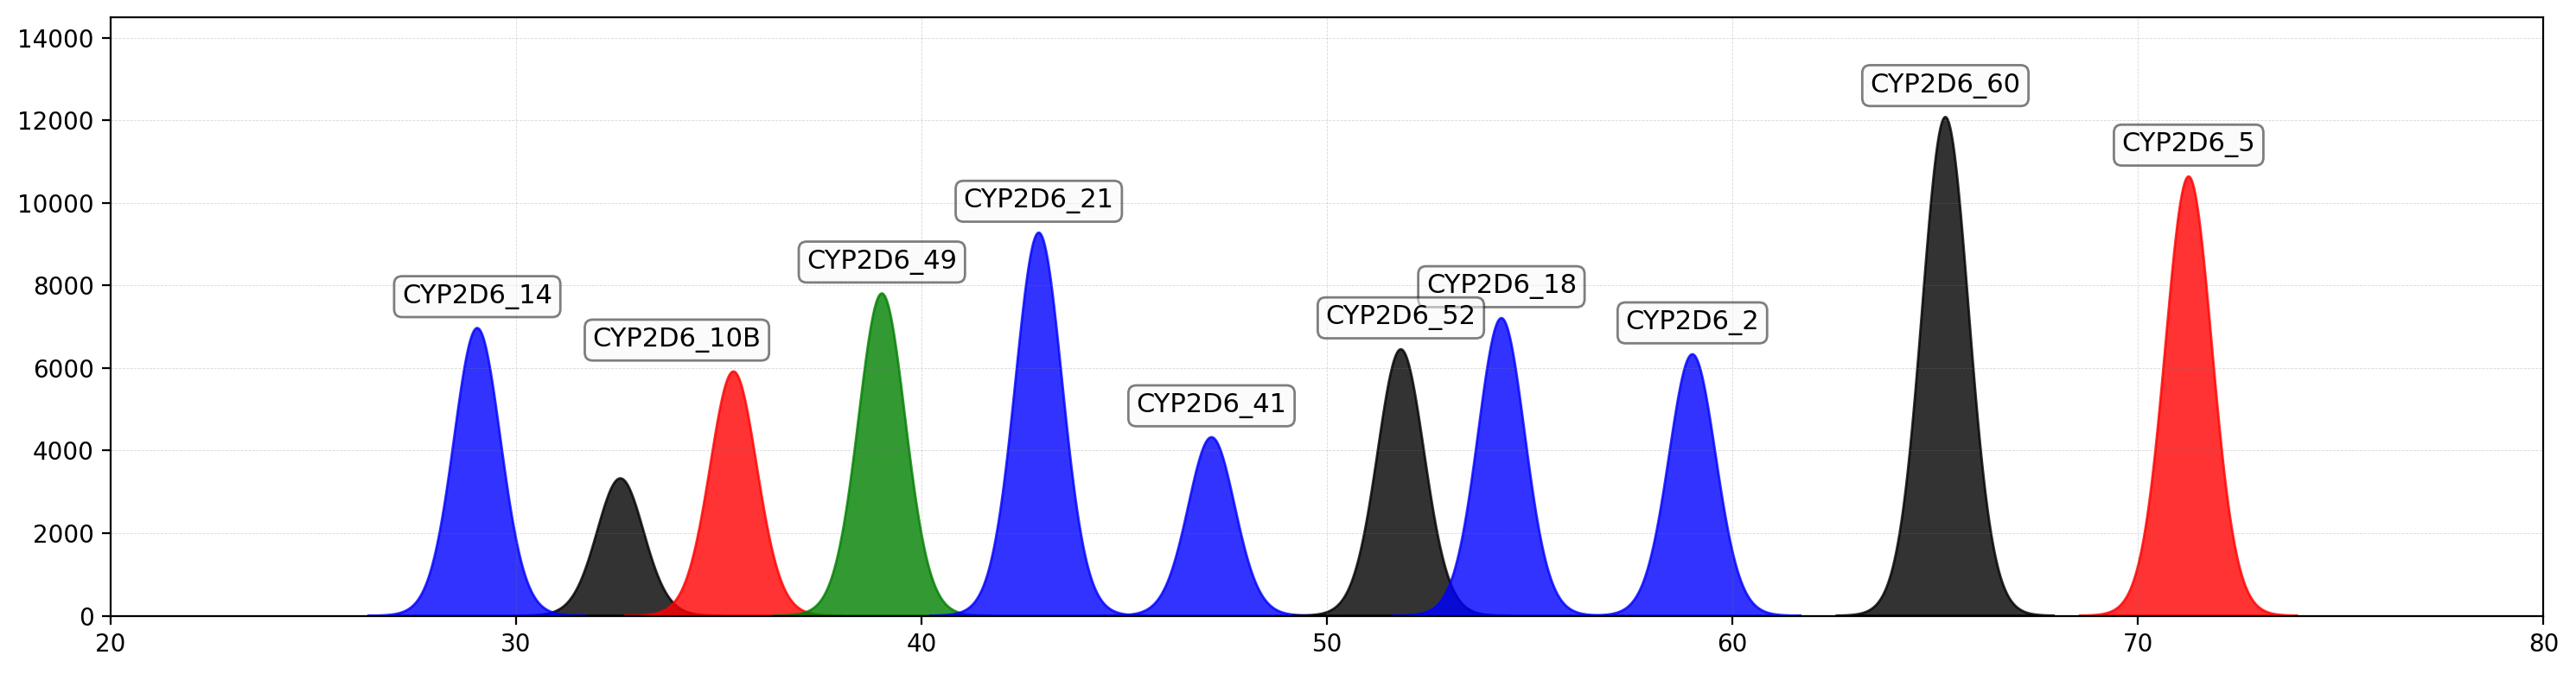

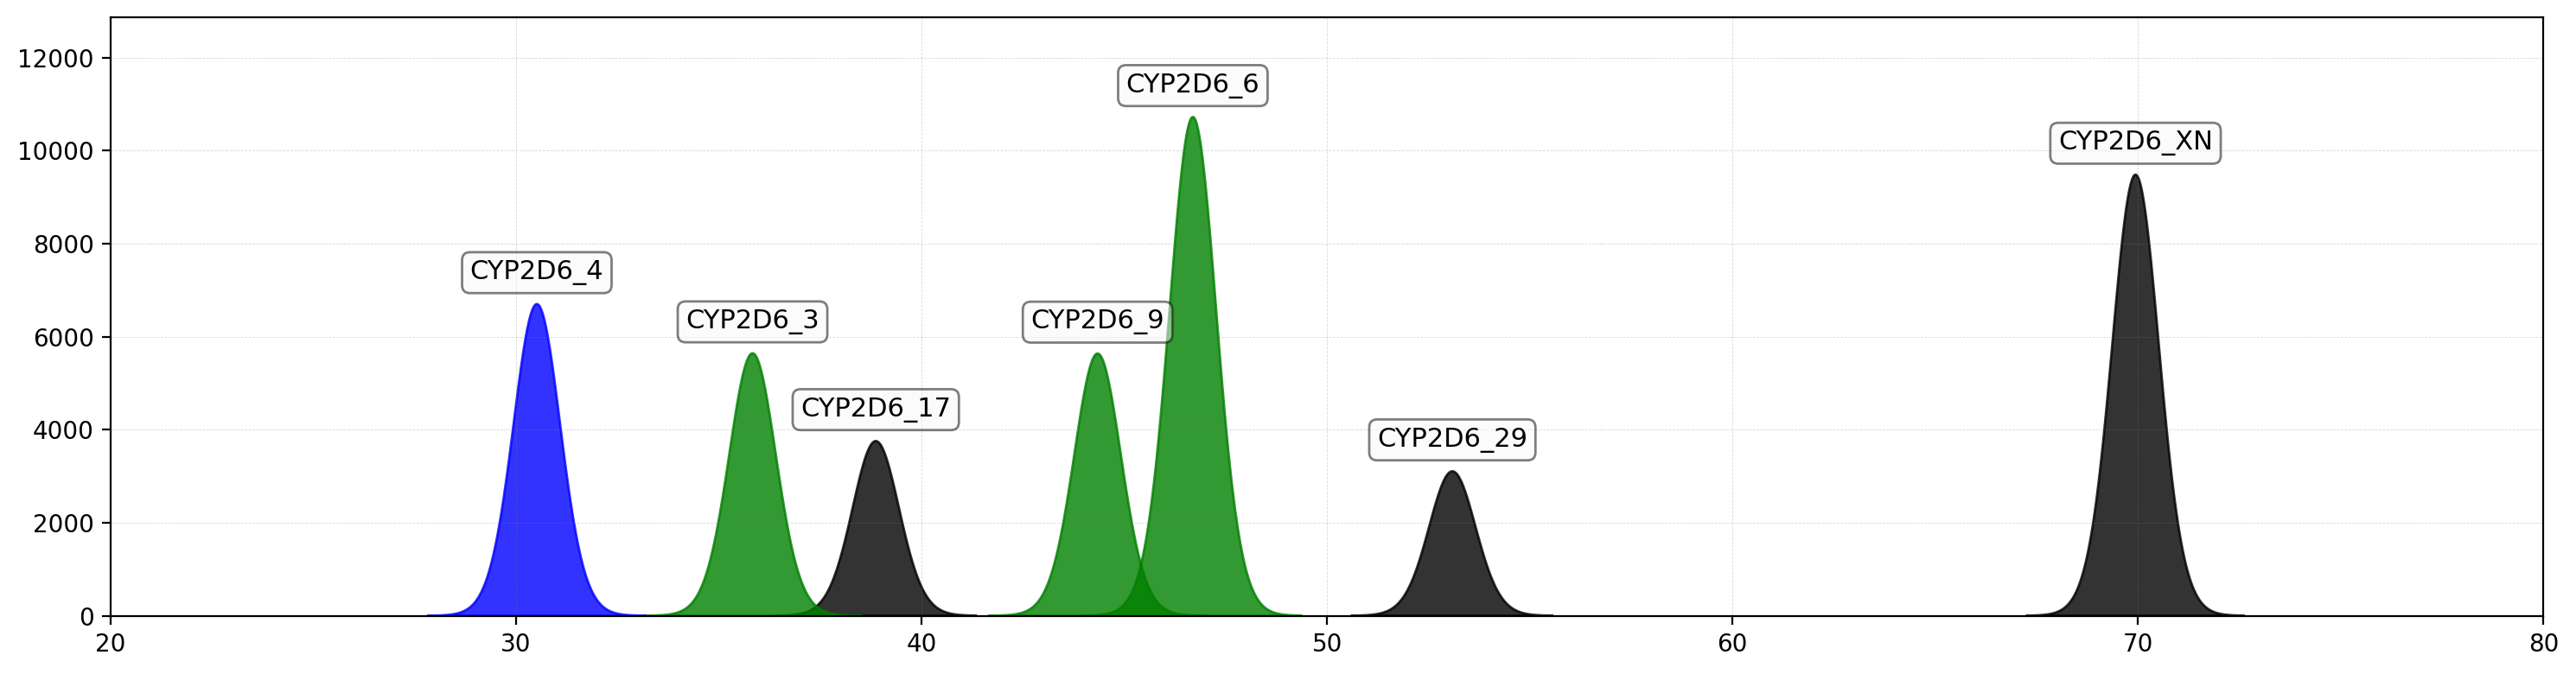

In [9]:
g2.plotting_qc('20180328-230857')

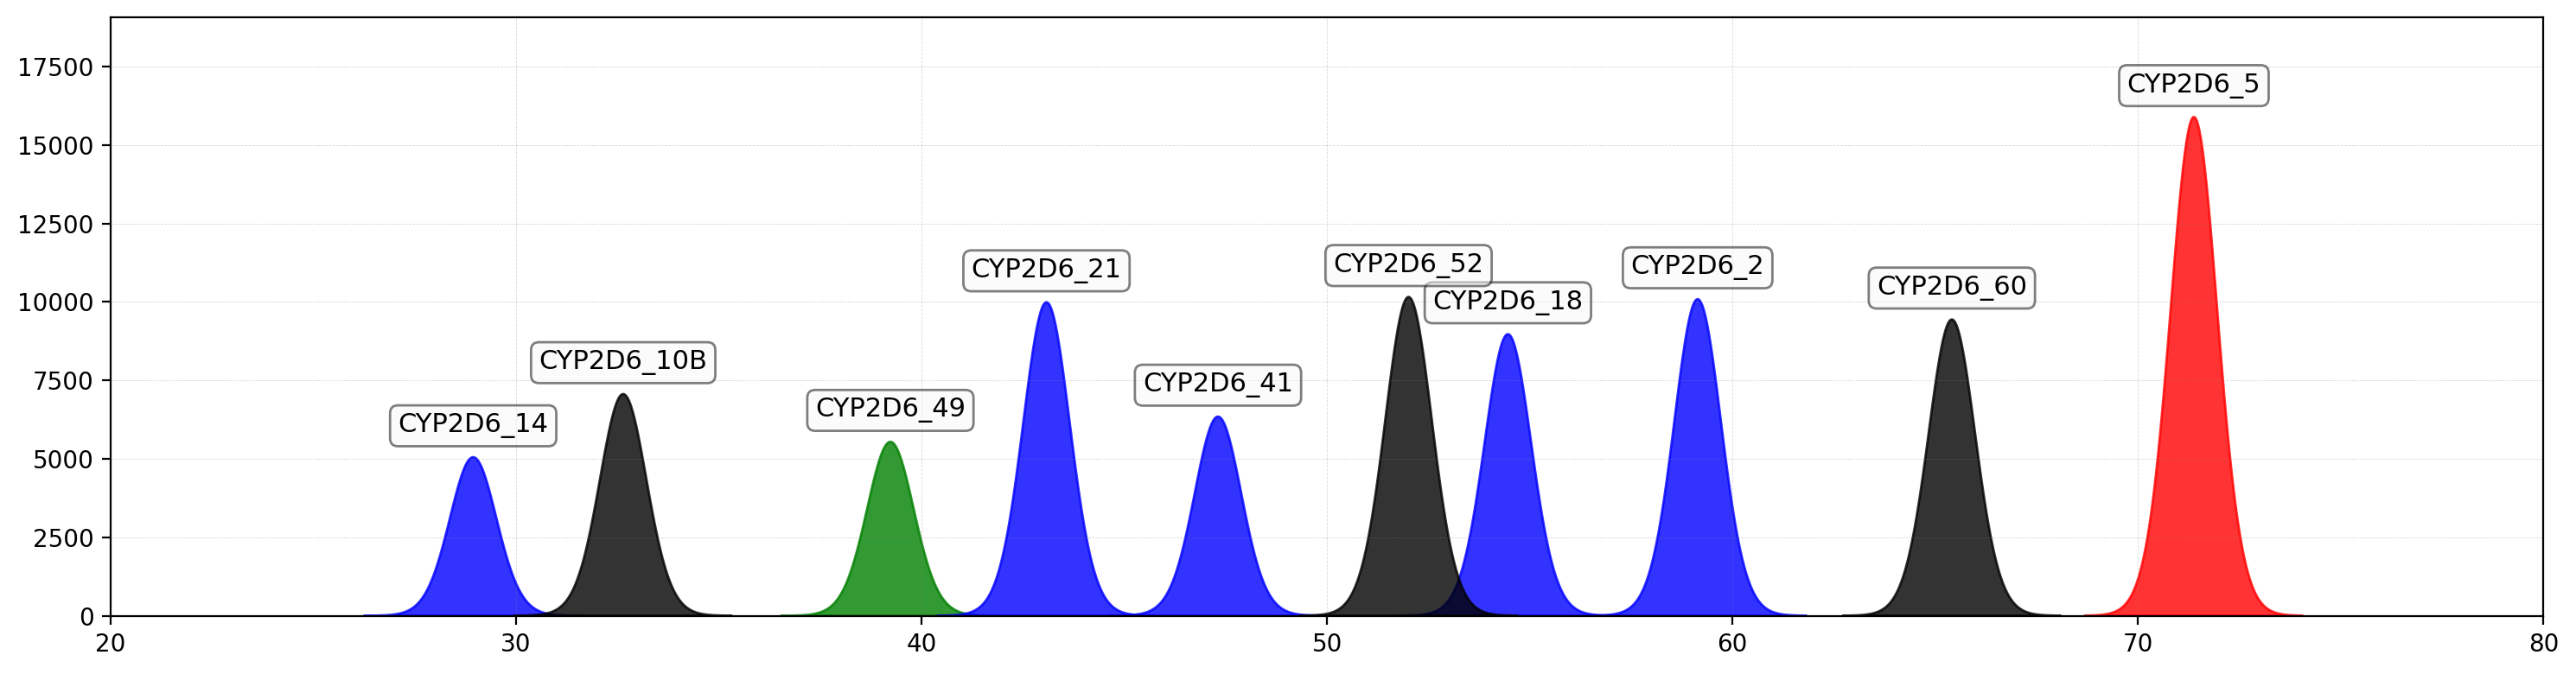

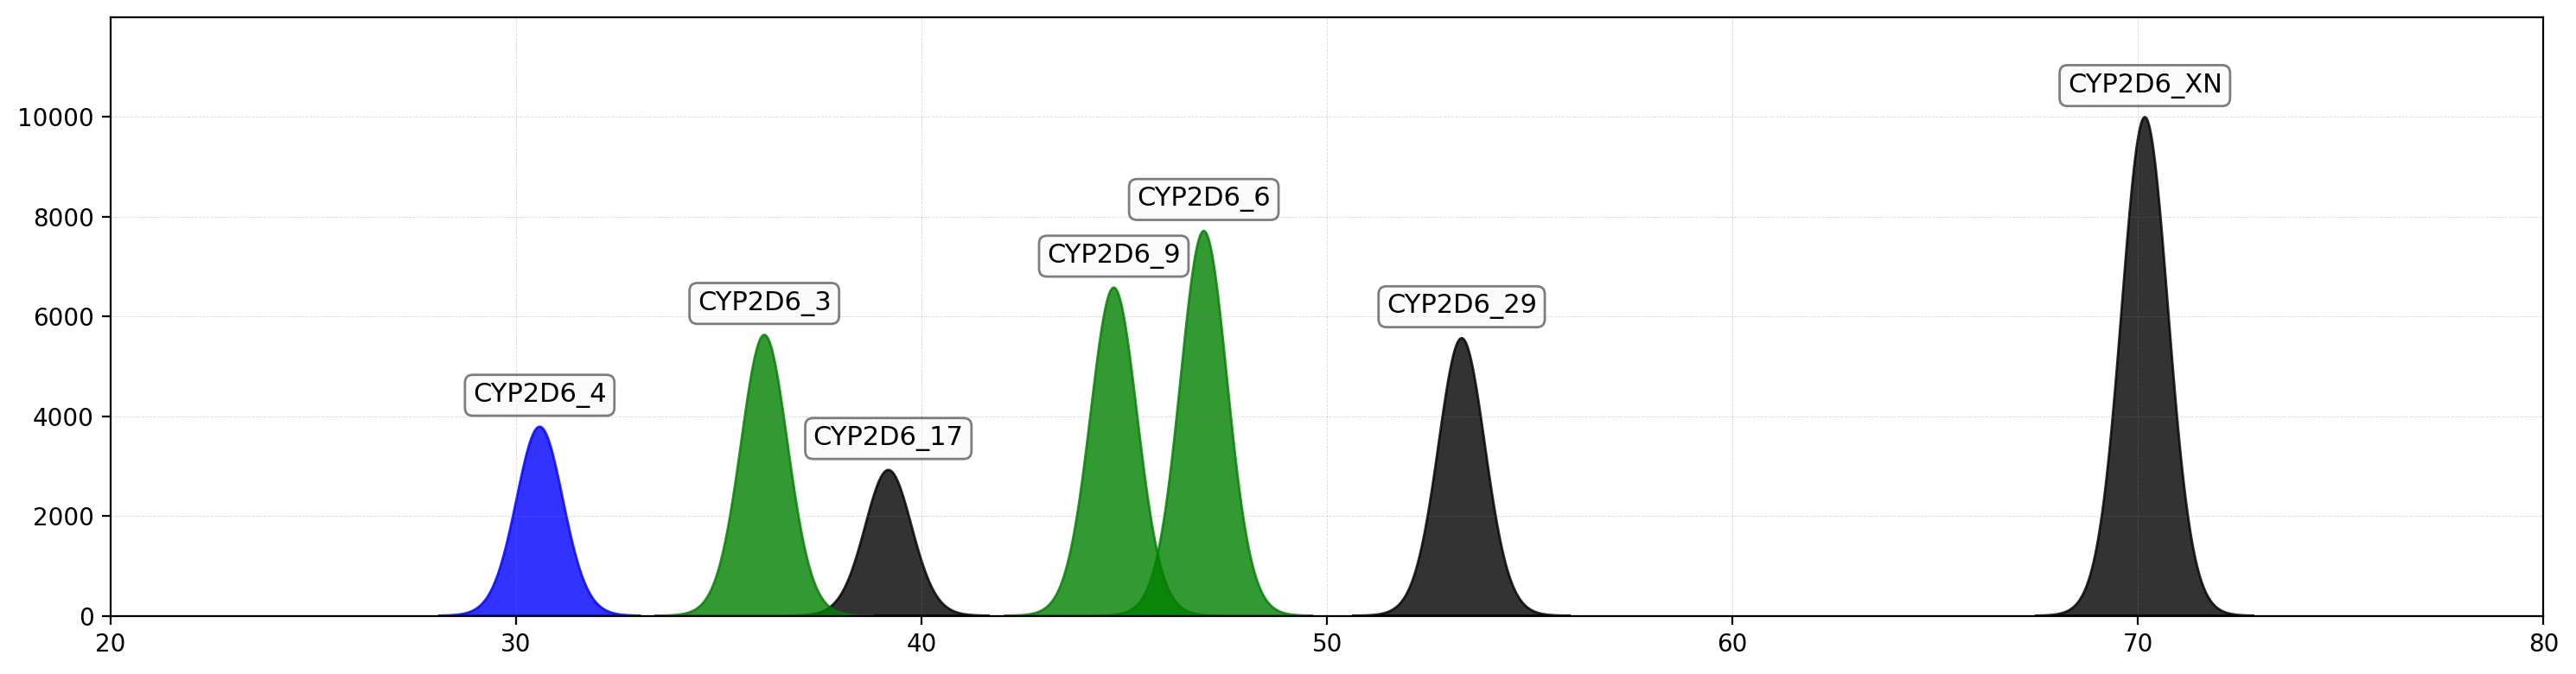

In [10]:
g2.plotting_qc('PTC')

# Update bin range to call genotype example

In [11]:
fsa_files = ['./raw_data/fsa/PA180404A/S1-20180328-230857_G02_SNaPshot50_POP7_E5_2018-04-06-16-40-43.fsa',
             './raw_data/fsa/PA180404A/S2-20180328-230857_H02_SNaPshot50_POP7_E5_2018-04-06-16-40-43.fsa']

liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]

import pickle
with open('./resource/tables.pdata', 'rb') as t:
    tables = pickle.load(t)

definition = Definition(tables)

s3_markers = generate_markers(peak_table)

s3_markers['CYP2D6_001'].update_allele_config(allele_number = 0, min_bin = 20, max_bin = 25)

s3 = call_from_fsa(fsa_files, s3_markers, liz120, val_plot=False, intensity_plot=False)

g3 = GenotypeResult()
g3.from_fsa_call(s3)

g3.allele_table(called_filter=False).head(4)

sample    gene      marker       label panel direction base  \
0  20180328-230857  CYP2D6  CYP2D6_001   CYP2D6_14    S1   Forward    G   
1  20180328-230857  CYP2D6  CYP2D6_001   CYP2D6_14    S1   Forward    A   
2  20180328-230857  CYP2D6  CYP2D6_002  CYP2D6_10B    S1   Forward    C   
3  20180328-230857  CYP2D6  CYP2D6_002  CYP2D6_10B    S1   Forward    T   

   basetype  min_bin  max_bin  min_height  is_forward  is_detected peak  \
0  wildtype       20       25         500           1        False        
1    mutant       27       36         500           1        False        
2  wildtype       28       38         500           1         True   32   
3    mutant       31       37         500           1         True   32   

    size  height status                                            message  \
0                        Peak(s) could not be detected. Please check pe...   
1                        Peak(s) could not be detected. Please check pe...   
2   32.6   901.0     ok                                                      
3  35.55  1019.0     ok                                                      

   color  
0   blue  
1  green  
2  black  
3    red

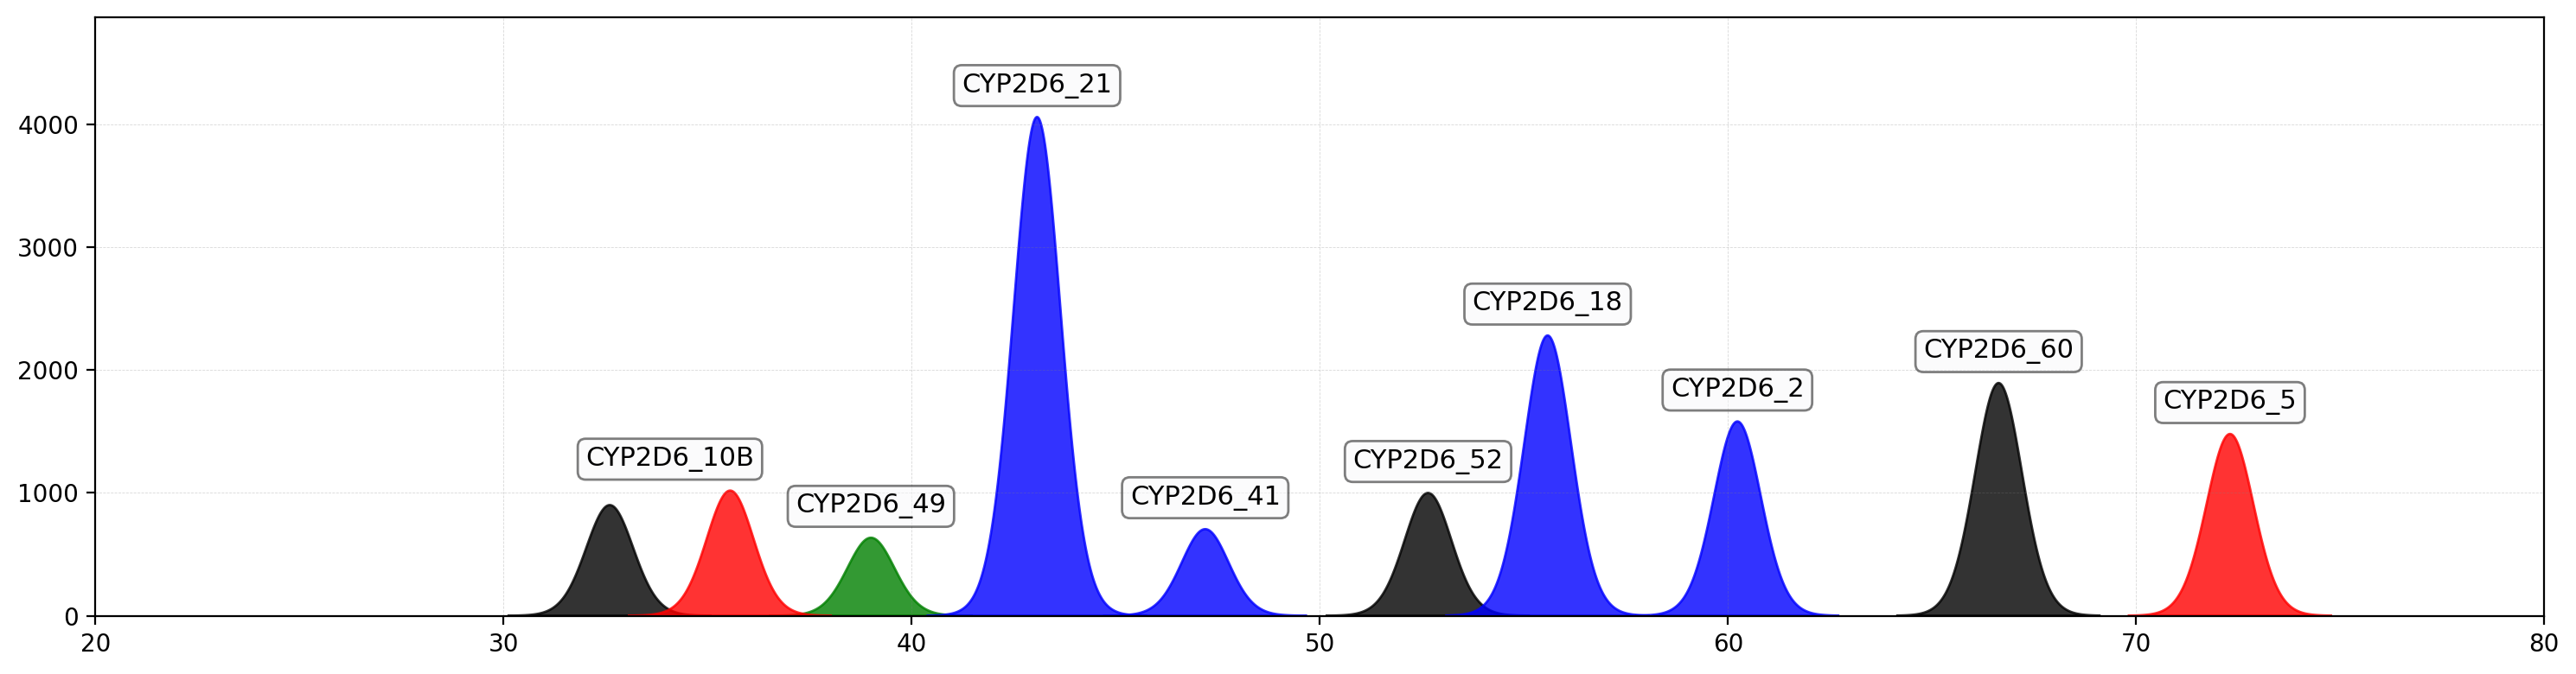

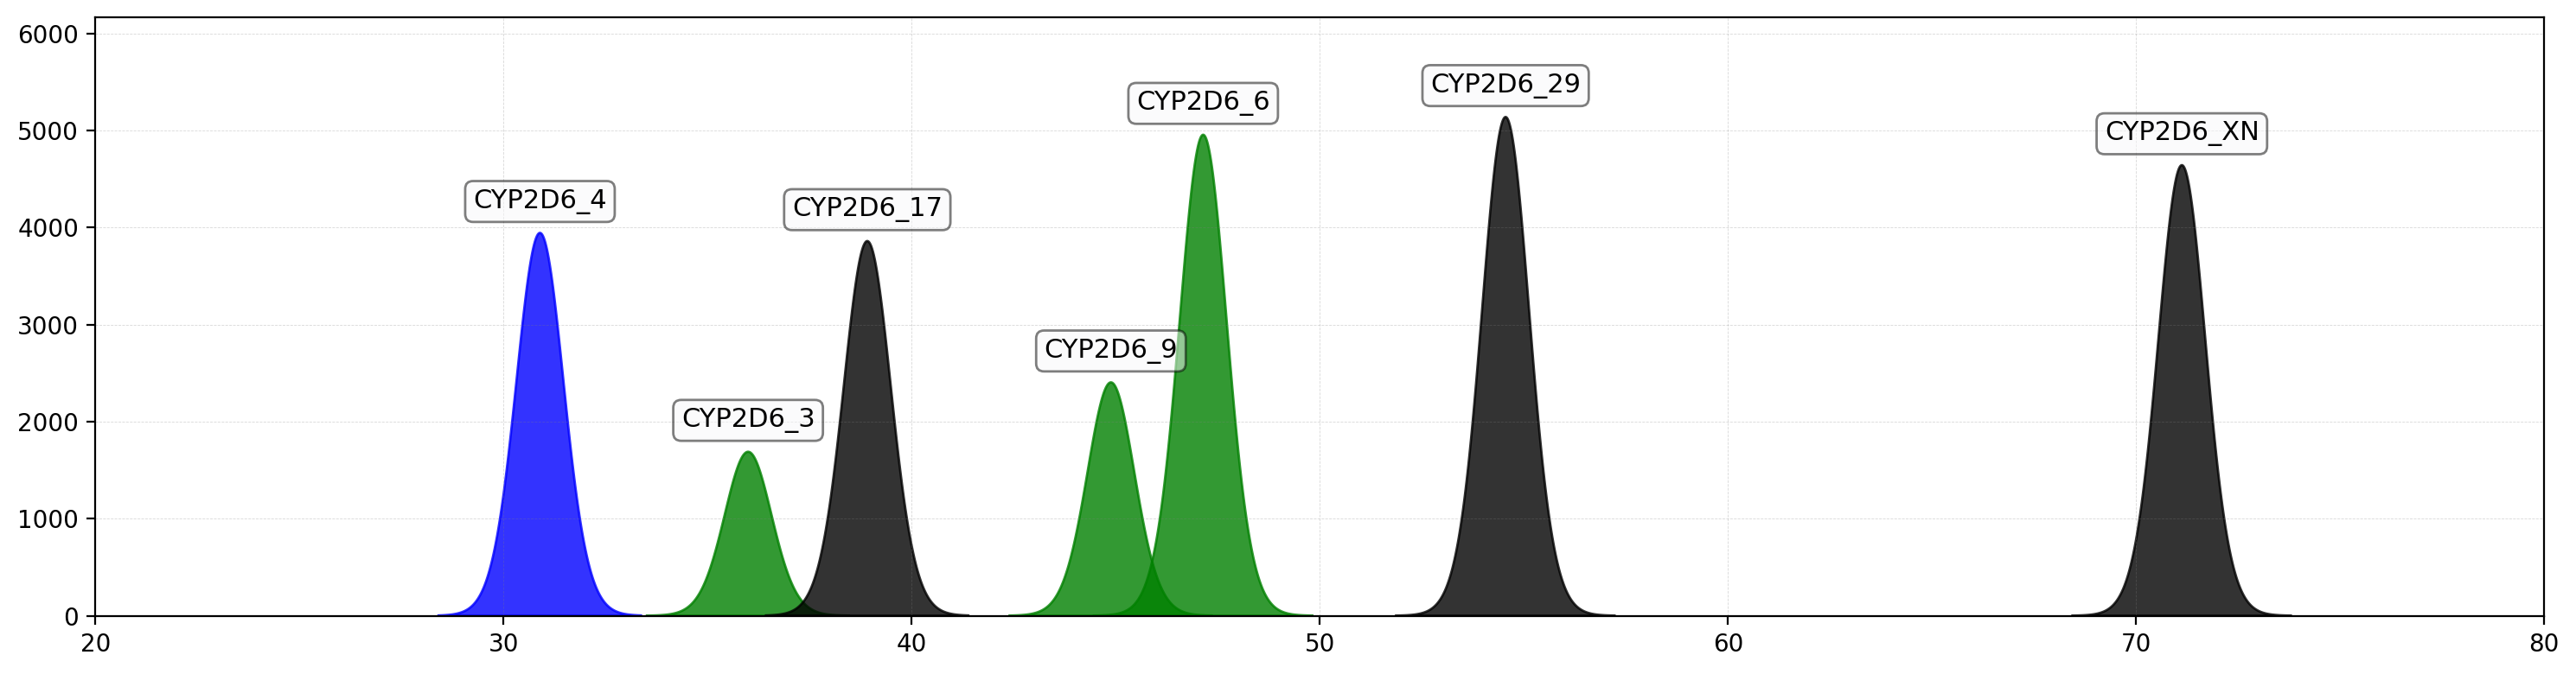

In [12]:
# qc plot
g3.plotting_qc('20180328-230857')

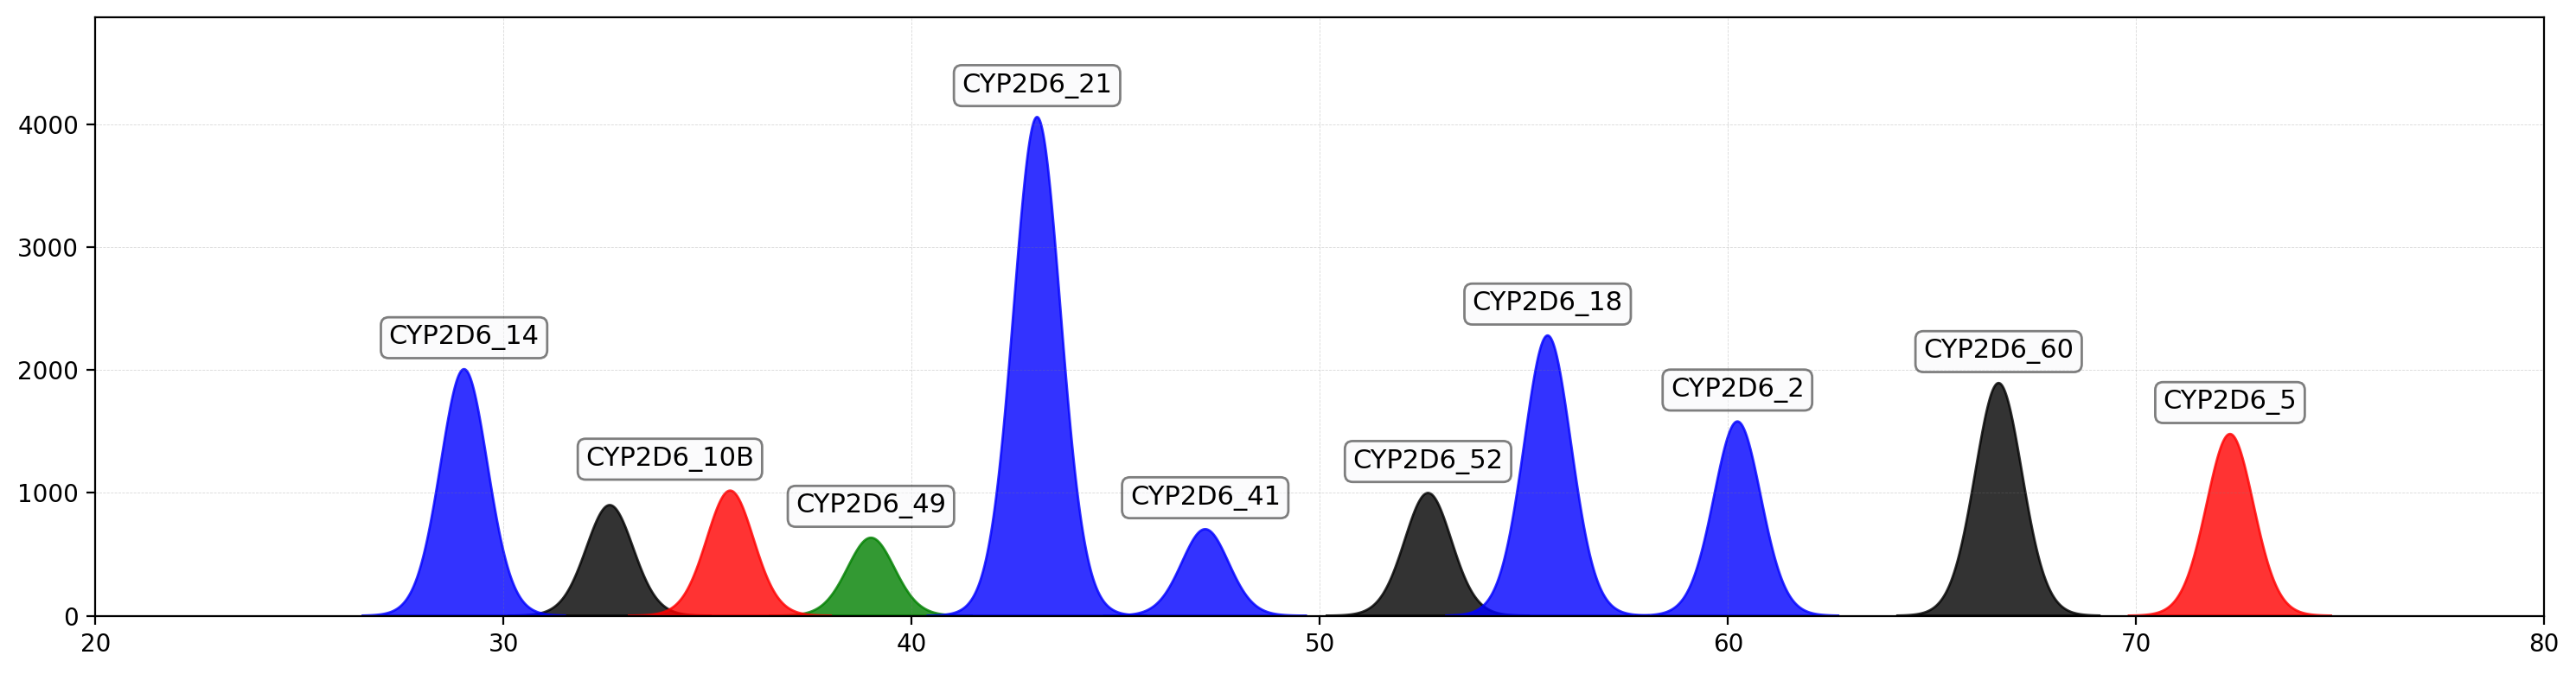

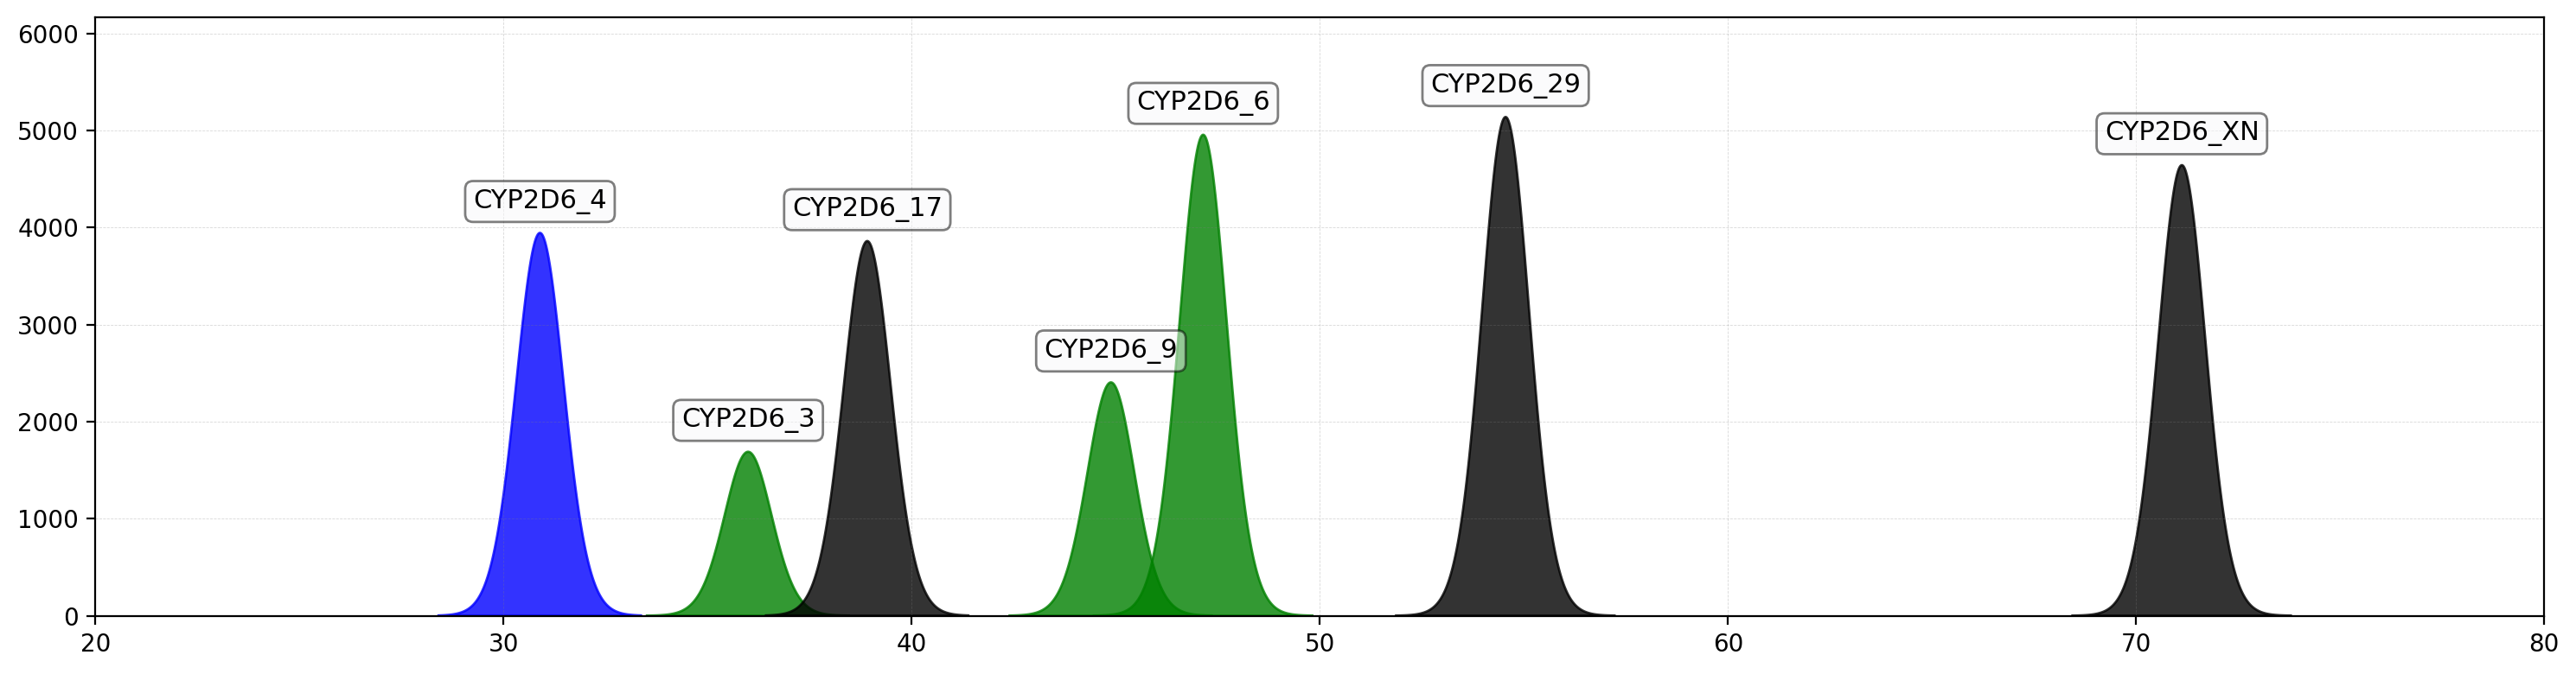

In [13]:
s3_markers['CYP2D6_001'].update_allele_config(allele_number = 0, min_bin = 27, max_bin = 36)

s3 = call_from_fsa(fsa_files, s3_markers, liz120, val_plot=False, intensity_plot=False)

g3_a = GenotypeResult()
g3_a.from_fsa_call(s3)

g3_a.plotting_qc('20180328-230857')

# Example of adjusting height

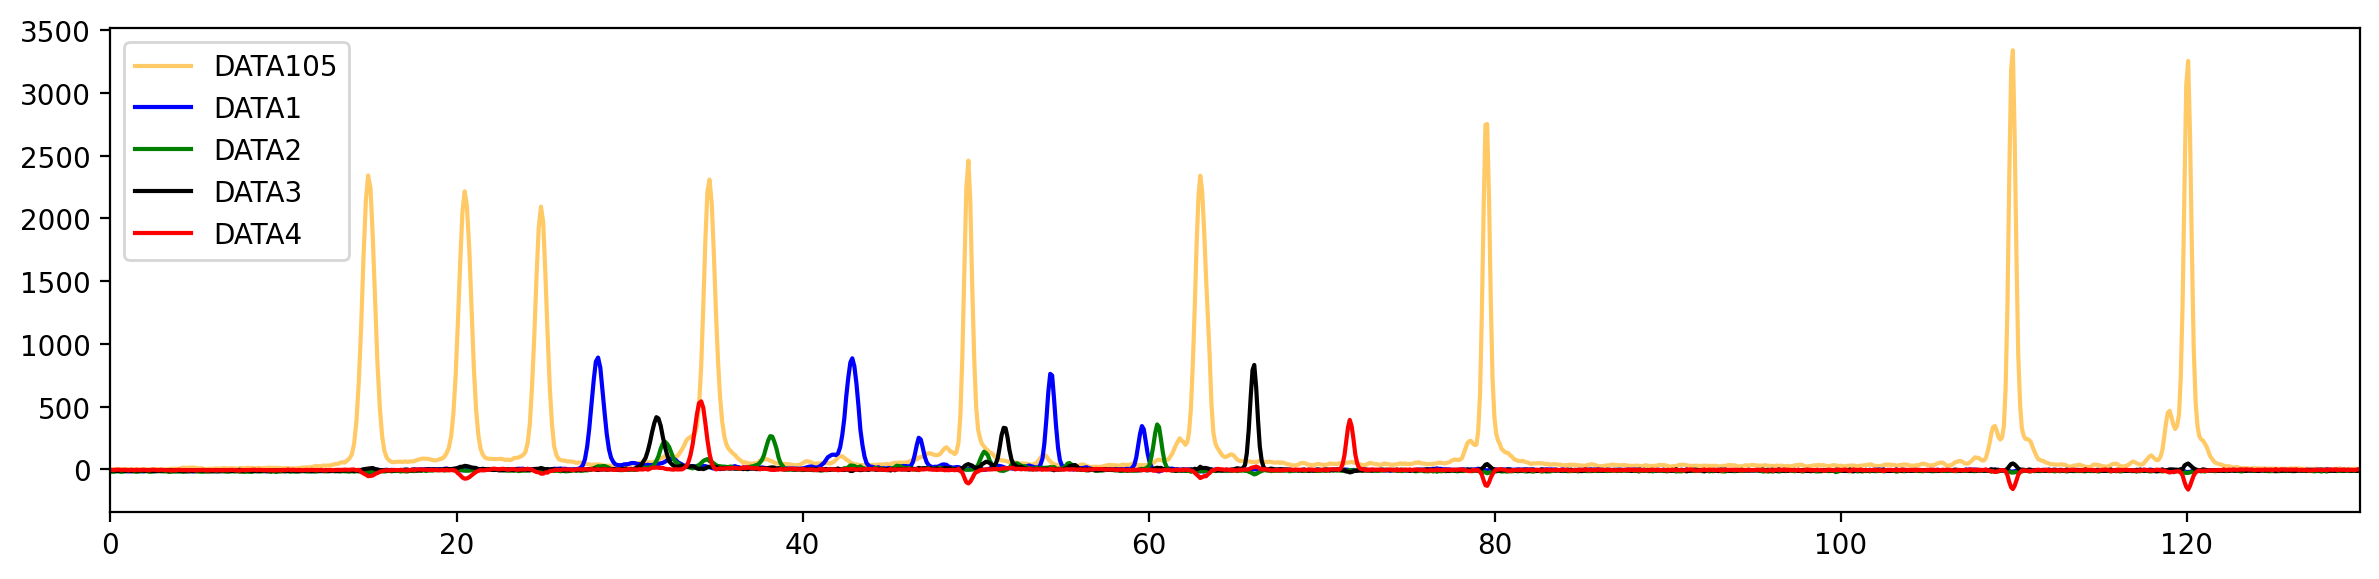

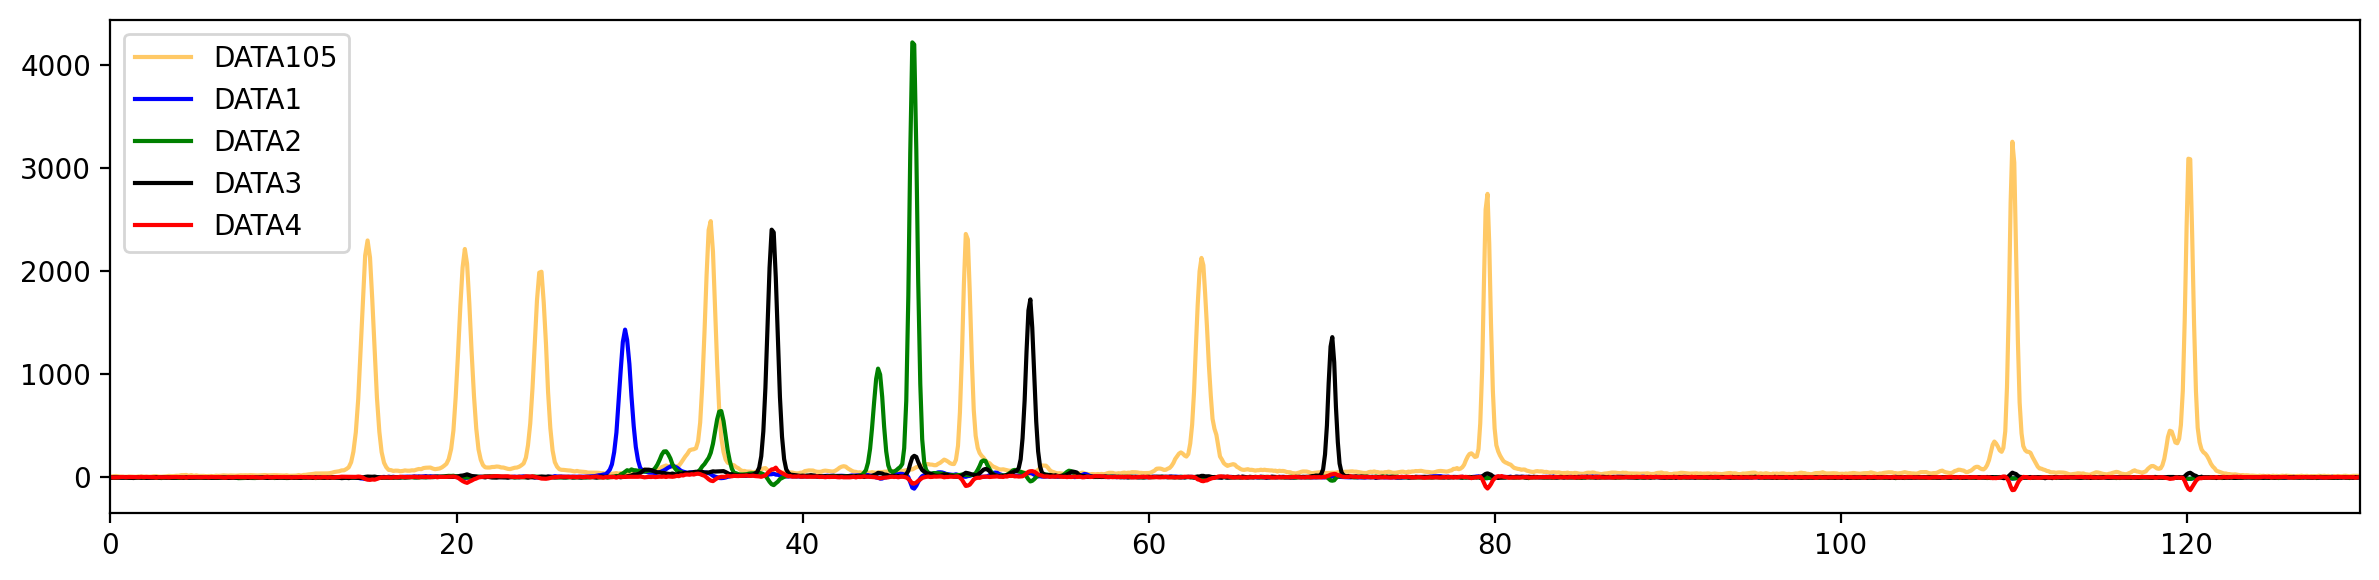

In [14]:
# update height
fsa_files = ['./raw_data/fsa/PA181114A/S1-20181106-730829_A10_SNaPshot50_POP7_E5_2018-11-23-16-40-43.fsa',
             './raw_data/fsa/PA181114A/S2-20181106-730829_B10_SNaPshot50_POP7_E5_2018-11-23-16-40-43.fsa']

liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]


s4_markers = generate_markers(peak_table)

s4 = call_from_fsa(fsa_files, s4_markers, liz120, val_plot=False, intensity_plot=True)


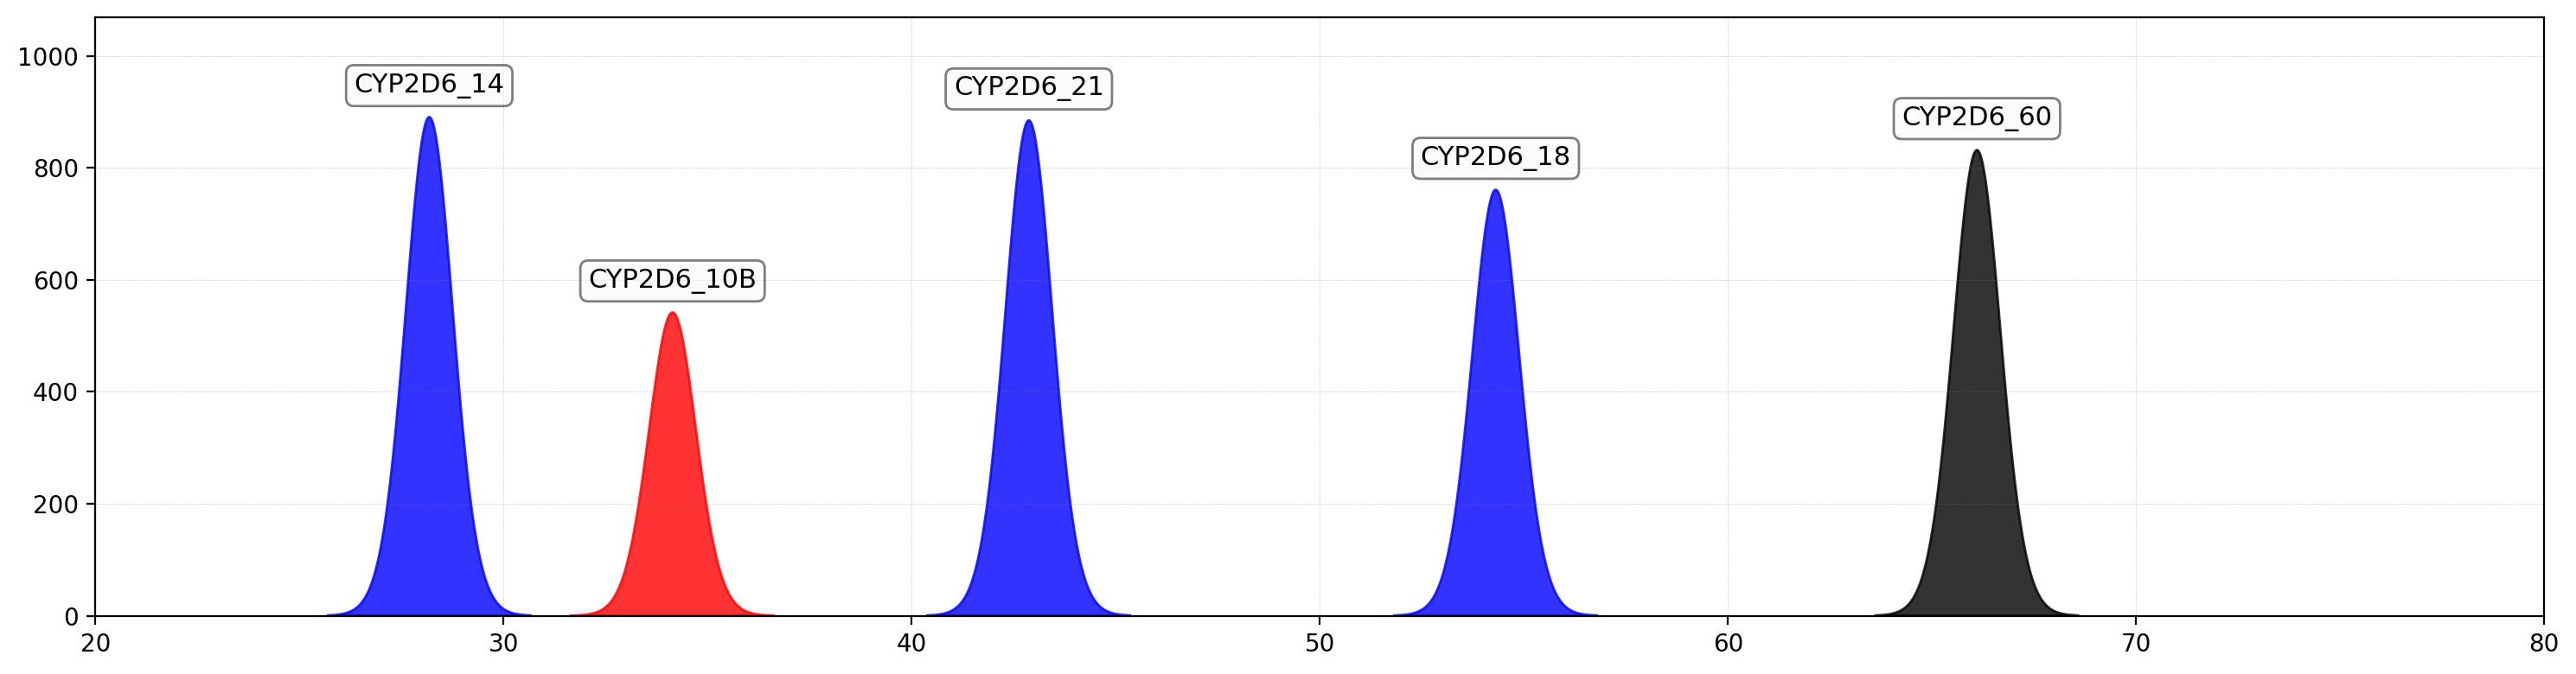

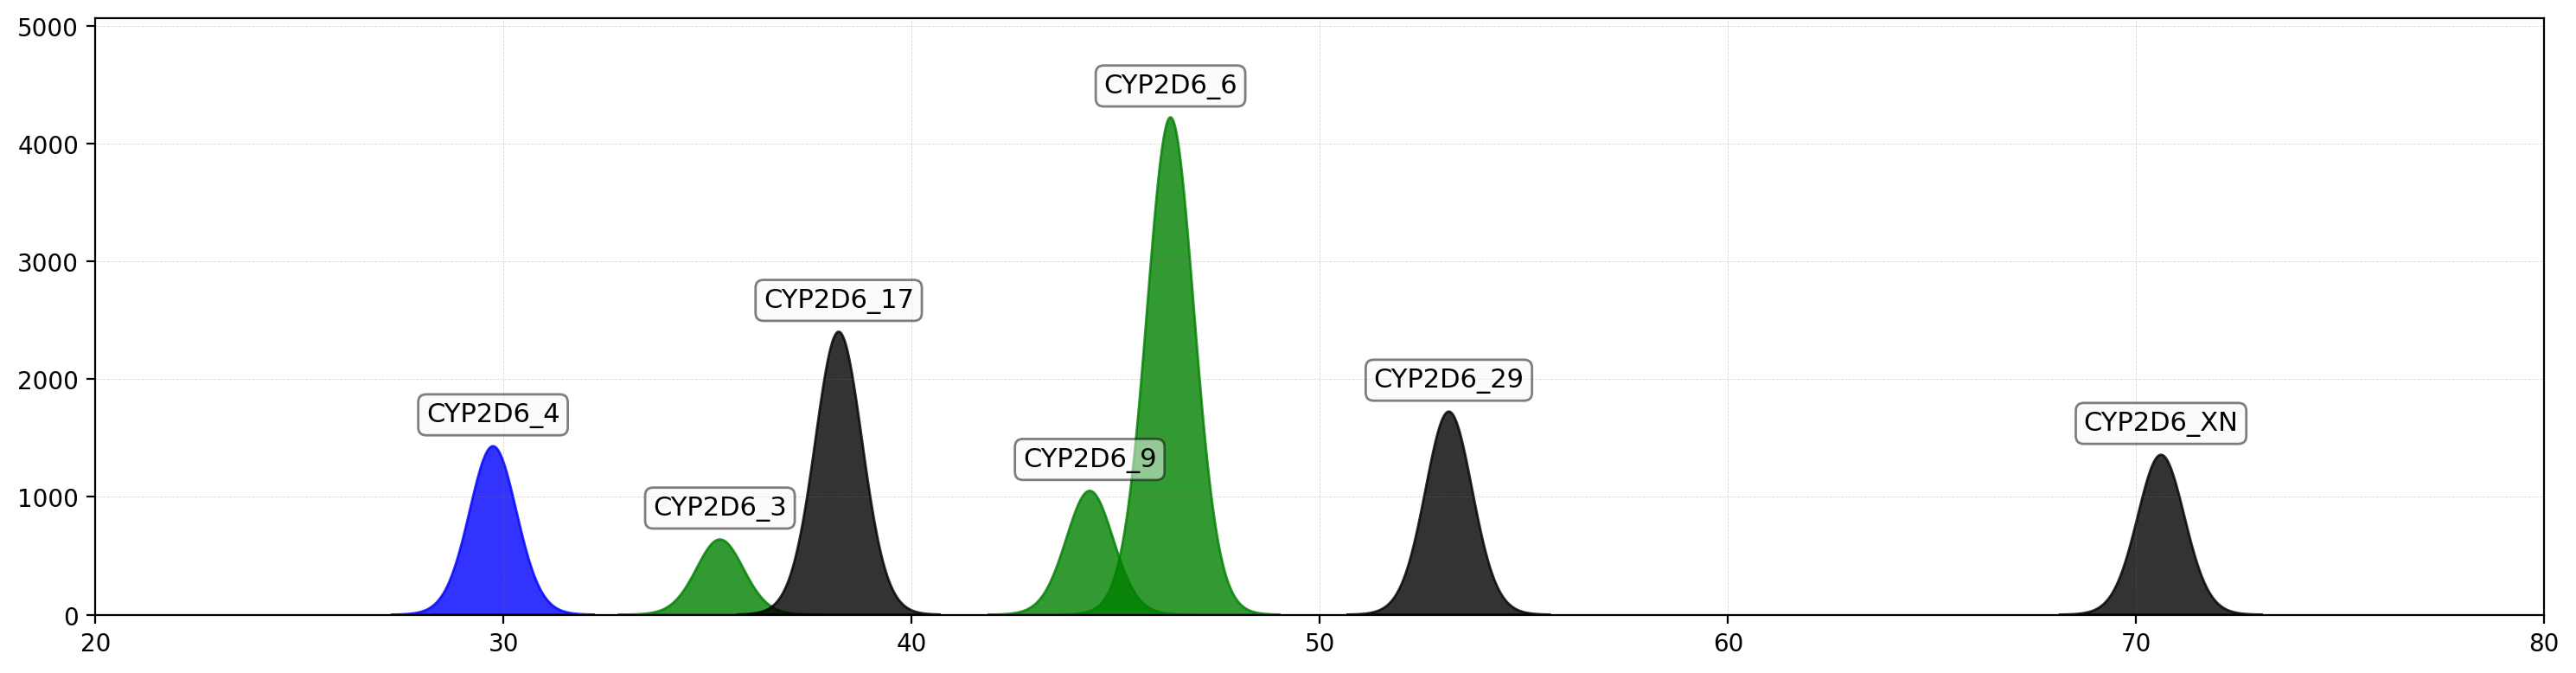

In [15]:
g4 = GenotypeResult()
g4.from_fsa_call(s4)

g4.plotting_qc('20181106-730829')

In [16]:
g4.allele_table(called_filter=False).head(4)

sample    gene      marker       label panel direction base  \
0  20181106-730829  CYP2D6  CYP2D6_001   CYP2D6_14    S1   Forward    G   
1  20181106-730829  CYP2D6  CYP2D6_001   CYP2D6_14    S1   Forward    A   
2  20181106-730829  CYP2D6  CYP2D6_002  CYP2D6_10B    S1   Forward    C   
3  20181106-730829  CYP2D6  CYP2D6_002  CYP2D6_10B    S1   Forward    T   

   basetype  min_bin  max_bin  min_height  is_forward  is_detected peak  \
0  wildtype       25       35         500           1         True   25   
1    mutant       27       36         500           1        False        
2  wildtype       28       38         500           1        False        
3    mutant       31       37         500           1         True   25   

    size height status                                            message  \
0  28.18  891.0     ok                                                      
1                       Peak(s) could not be detected. Please check pe...   
2                       Peak(s) could not be detected. Please check pe...   
3  34.14  542.0     ok                                                      

   color  
0   blue  
1  green  
2  black  
3    red

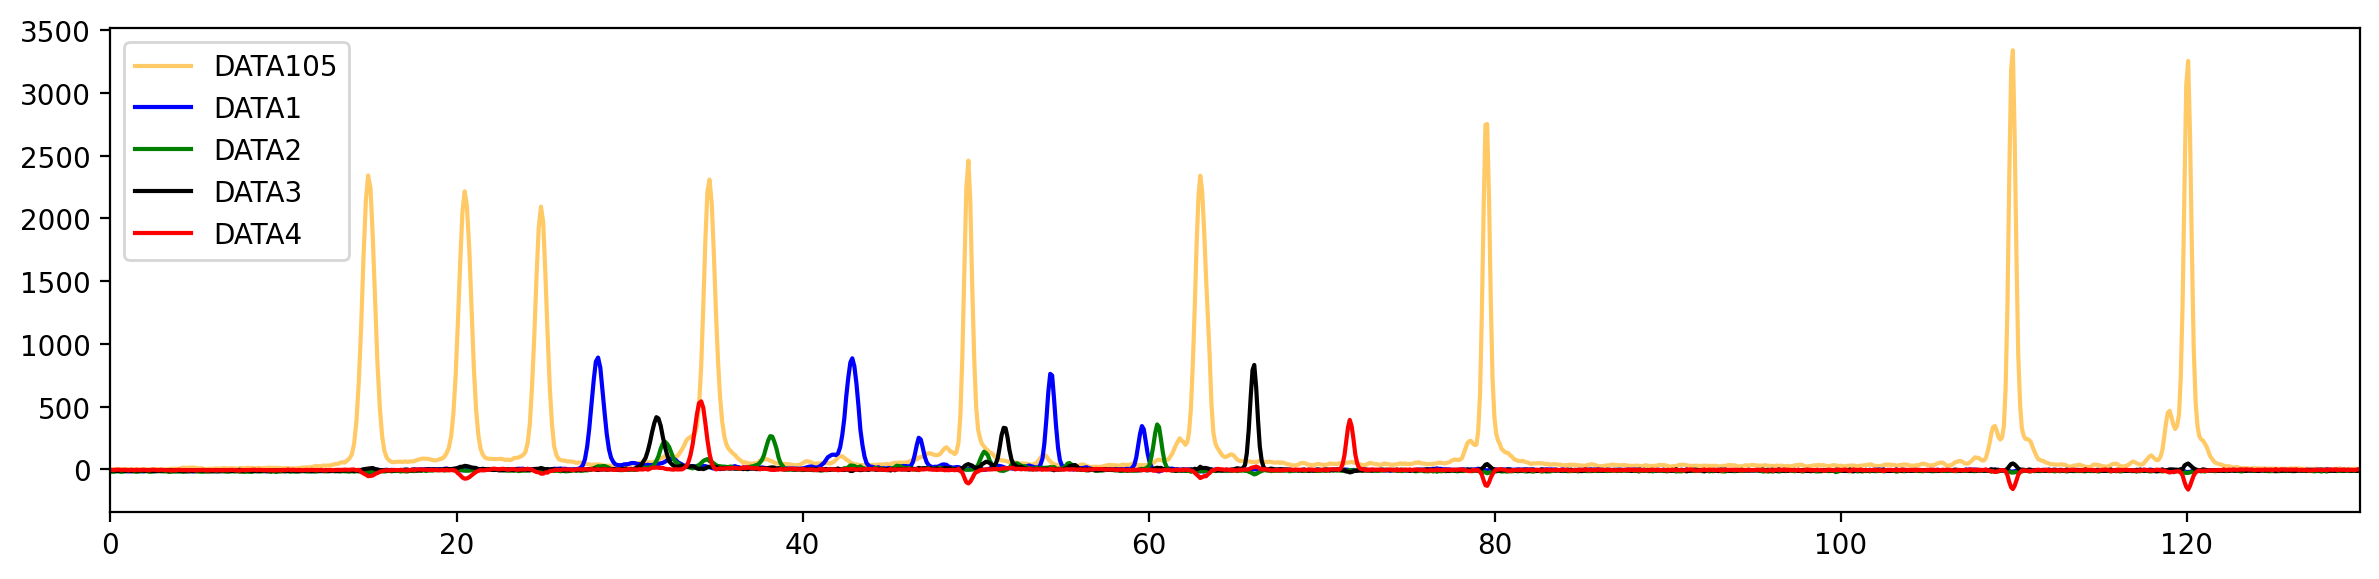

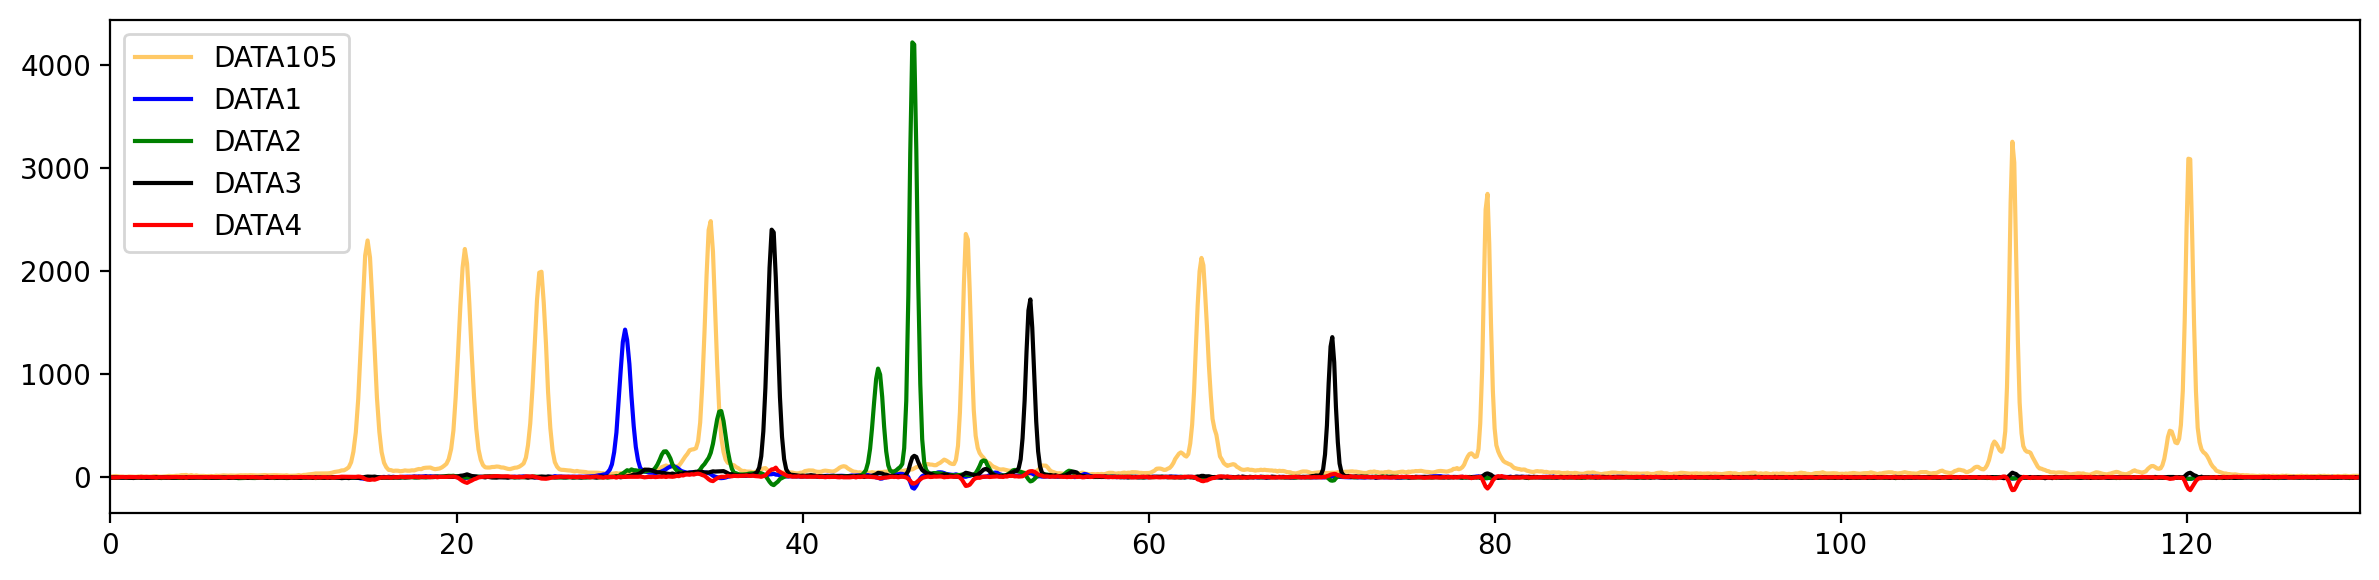

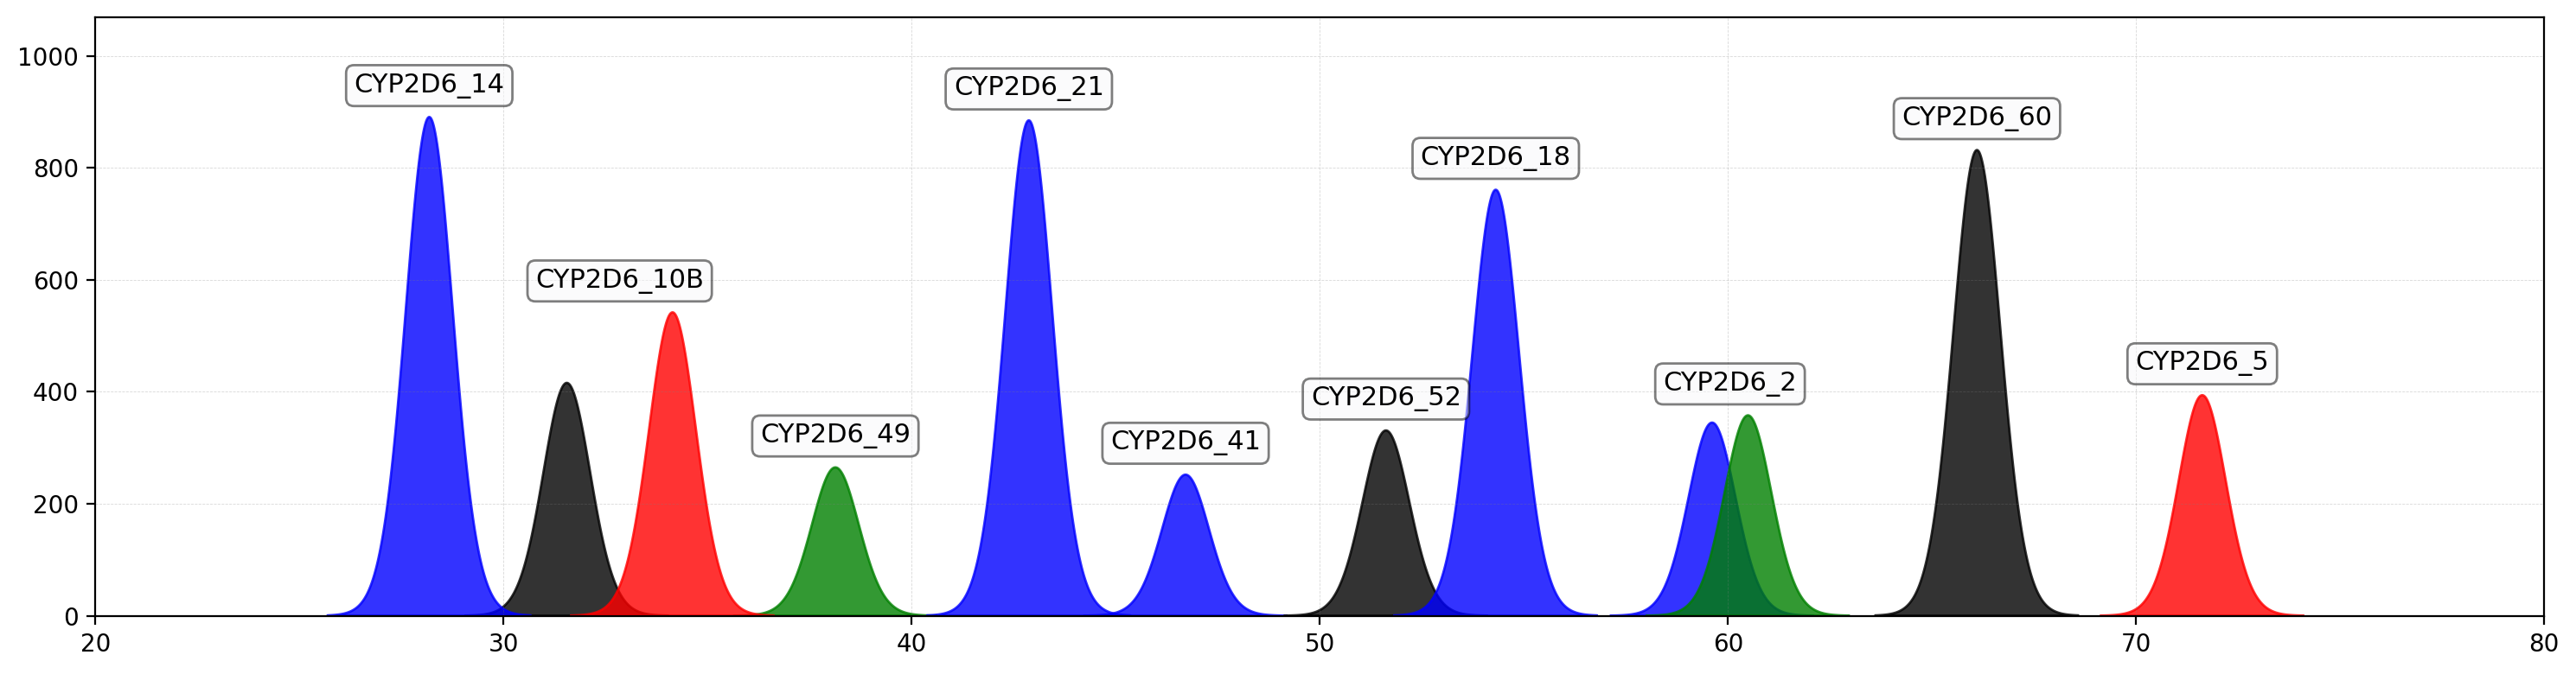

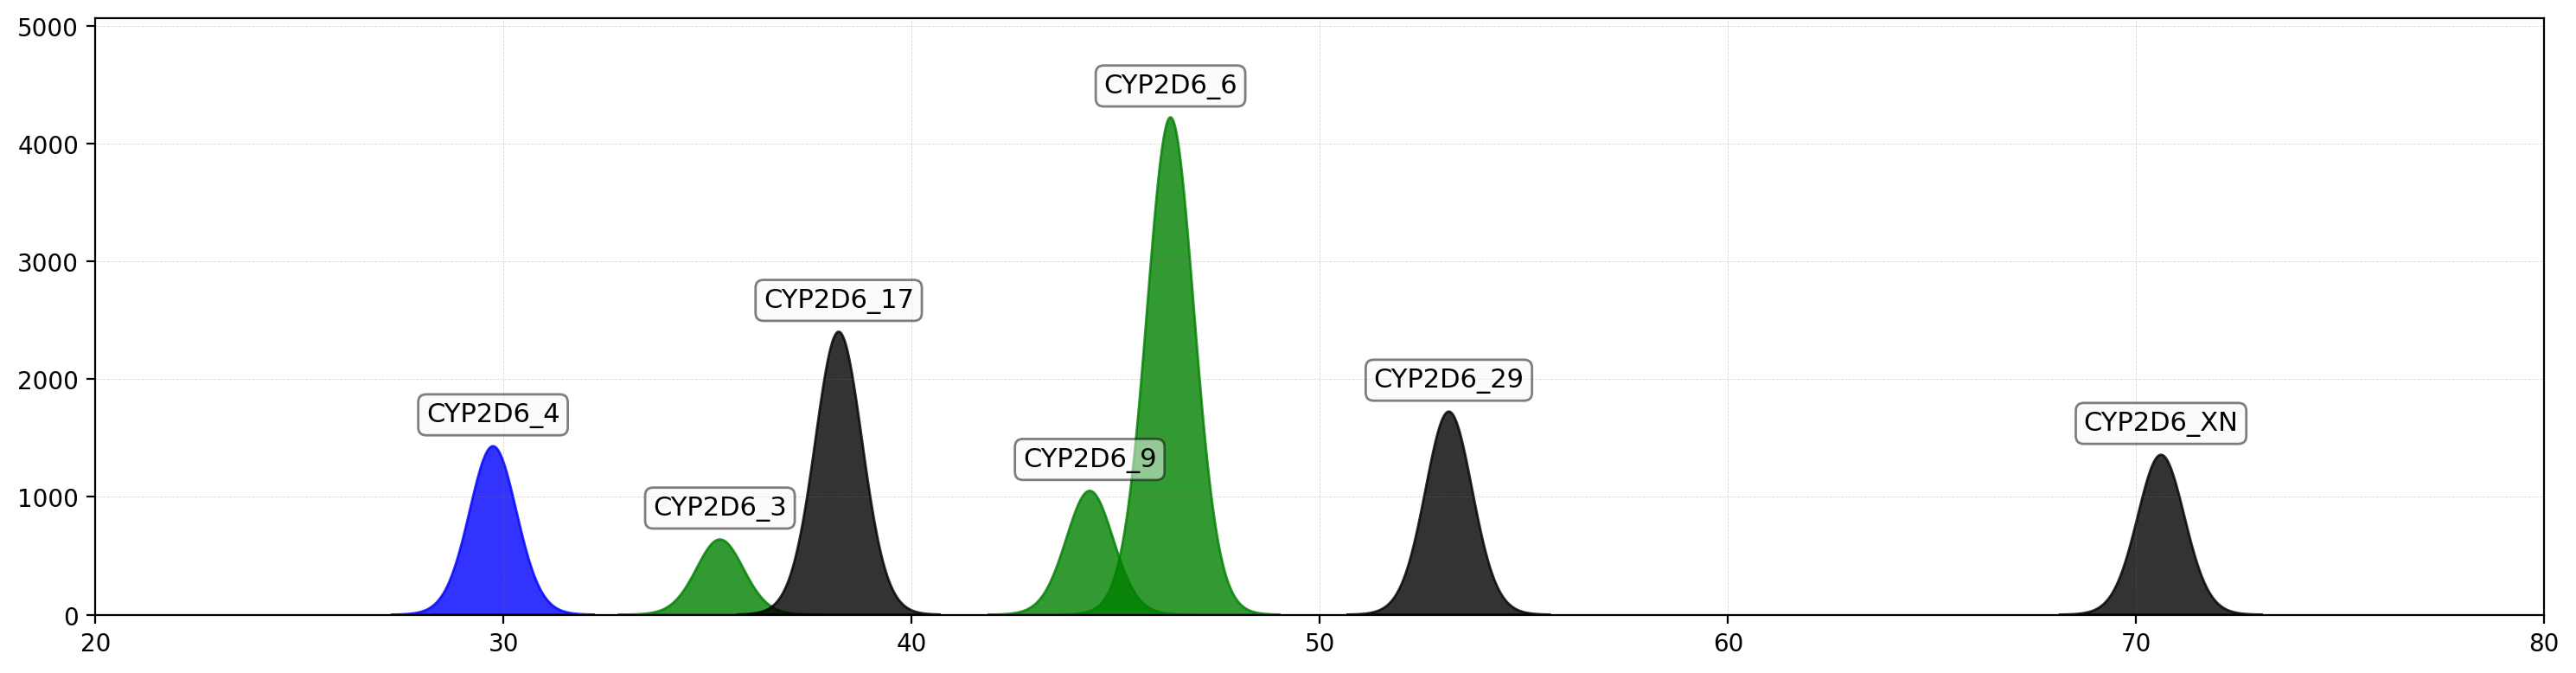

In [17]:

for marker_name in s4_markers:
    marker = s4_markers.get(marker_name)

    for num, _ in enumerate(marker.alleles):
        marker.update_allele_config(allele_number= num, min_height =250)


s4 = call_from_fsa(fsa_files, s4_markers, liz120, val_plot=False, intensity_plot=True)
g4 = GenotypeResult()
g4.from_fsa_call(s4)

g4.plotting_qc('20181106-730829')

### Validate data from PGx team

#### Predefined

In [34]:
liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]

import pickle
with open('./resource/tables.pdata', 'rb') as t:
    tables = pickle.load(t)

definition = Definition(tables)

#### Generate sample file

In [4]:
import os
valid_dir = './validation/validate_data/FSA/'
fsa_files = sorted([f'{valid_dir}{f}' for f in os.listdir(valid_dir) if 'fsa' in f])

sample_name = [extract_sample_name(f.split("/")[-1]) for f in fsa_files]

# check duplication
from collections import Counter

for s, c in Counter(sample_name).items():
    if c != 2:
        print(s)

# make sample table
sample_df = pd.DataFrame({'sample': sample_name, 'path': fsa_files})

# sample_df.to_excel('./validation/results/all_sample_list.xlsx', index=False)

#### Generate peak table for each sample

In [6]:
temp_peak = pd.read_excel('./resource/test_bin_peak.xlsx')
valid_result = './validation/results/'

# for sample in sample_df['sample'].unique():
#     sample_folder = f'{valid_result}{sample}'
#     # os.mkdir(sample_folder)
#     temp_peak.to_excel(f'{sample_folder}/{sample}.xlsx', sheet_name='peak_table', index=False)
    # os.remove(f'{valid_result}{sample}.xlsx')

#### Identification of reference peaks

In [ ]:
ref_dir = './validation/reference_peaks/'

# height = [400, 500, 600, 700, 800]
height = [300]

from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(f'{ref_dir}reference_peak_plots.pdf')

ref_peak_df = pd.DataFrame()

for h in height:
    count = 0
    for _,row in sample_df.iterrows():
        fsa = FSA(row['path'])

        peaks, height = find_peaks(fsa.reference_intensity, height=h)

        if len(peaks) > 9:
            pro = peak_prominences(fsa.reference_intensity, peaks)[0]
            pro_sort = np.sort(pro)[::-1]
            m_pro = pro_sort[9]

            peaks, height = find_peaks(fsa.reference_intensity, height=h, prominence=m_pro+0.001)

        if len(peaks) > 9:
            diff = np.sort(np.diff(peaks))[::-1]
            # print(len(diff))
            m_dist = diff[8]
            peaks, height = find_peaks(fsa.reference_intensity, height=h, distance=m_dist+0.001)

        if len(peaks) == 9:
            count +=1
            plt.figure(figsize=(15, 4), dpi=200)
            plt.plot(fsa.reference_intensity, color ='orange', alpha=0.5)
            
            for p,hi in zip(peaks, height['peak_heights']):
                plt.text(p, hi, 'x', ha='center')
                plt.title(fsa.name)

            pdf.savefig()

            tmp = pd.DataFrame({'sample': fsa.name, 'peak': peaks, 'height': height['peak_heights'], 'size': liz120})
        
            ref_peak_df = pd.concat([ref_peak_df, tmp])

    print(f'{str(h)}: {count}')
    
pdf.close()

ref_peak_df.to_excel(f'{ref_dir}ref_peak_detection_details.xlsx', index=False)

In [36]:
# import dtale

# d = dtale.show(ref_peak_df)
# d.open_browser()

import seaborn as sns

import plotly.express as px

fig = px.box(ref_peak_df, x ='size', y ='height', points='all')

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = liz120,
        ticktext = liz120
    ),
    title = "Reference peaks and intensity",
    xaxis_title = 'Reference size (bp)',
    yaxis_title = 'Intensity'
)

fig.show()
fig.write_html(f'{ref_dir}ref_size_and_intensity.html')

In [35]:
fig = px.box(ref_peak_df, x ='peak', y ='size')

fig.update_layout(
    # xaxis = dict(
    #     tickmode = 'array',
    #     tickvals = liz120,
    #     ticktext = liz120
    # ),
    title = "Reference peaks and cycles",
    xaxis_title = 'Number of cycles (data points)',
    yaxis_title = 'Refernce size (bp)'
)
fig.update_traces(orientation='h')
fig.show()

fig.write_html(f'{ref_dir}ref_size_and_data_points.html')

#### Call genotype from validate samples

* All peaks will call with intensity over than 1000
* Samples can not be called will return genotype as ""


In [8]:
from copy import copy
import plotly.graph_objects as go

sample_list = sample_df['sample'].unique()
gene = 'CYP2D6'

allele_table_df = pd.DataFrame()
marker_table_df = pd.DataFrame()
genotype_result = pd.DataFrame()

for sample in sample_list:
    fsa_files = sample_df[sample_df['sample'] == sample]['path'].tolist()

    sample_folder = f'{valid_result}{sample}/'
    peak_file = f'{sample_folder}{sample}.xlsx'
    s_peak_table = pd.read_excel(peak_file, sheet_name='peak_table')

    target_markers = generate_markers(s_peak_table)

    try:
        genotype, support_data = call_from_fsa(fsa_files, target_markers, liz120, val_plot=False, intensity_plot=False)
        # genotype = GenotypeResult()
        # genotype.from_fsa_call(called)

        for s in genotype.sample_list:
            s_data = genotype.marker_table(s)
            targets = definition.get_target_marker(gene)
            s_pattern = generate_sample_pattern(s_data, targets['marker_name'])
            result = call_star_allele(s_pattern, targets['pattern'])

            # QC plots
            # figs = genotype.plotting_qc(s, showfig=False)
            # for fig in figs:
            #     figs.get(fig).savefig(f'{sample_folder}{s}-{fig}-QC.png', dpi =150)

        allele_table_df = pd.concat([allele_table_df, genotype.allele_table(called_filter=False)])
        marker_table_df = pd.concat([marker_table_df, genotype.marker_table()])
        geno = pd.DataFrame({'sample': sample, 'genotype':result}, index=[0])
        genotype_result = pd.concat([genotype_result, geno])

        # with pd.ExcelWriter(peak_file, engine='openpyxl', mode='a') as writer:
        #     genotype.allele_table(called_filter=False).to_excel(writer, sheet_name='allele_table', index=False)
        #     genotype.marker_table().to_excel(writer, sheet_name='marker_table', index=False)
        #     geno.to_excel(writer, sheet_name='genotype_result', index=False)
        #     writer.save()

        figs = plot_intensity(genotype, support_data)
        
        with open(f'{sample_folder}{sample}_raw_intensity.html', 'a') as f:
            for fig in figs:
                f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

    except Exception as e:
        print(f'{sample}, {e}')

# excel = pd.ExcelWriter('./validation/all_validation_result_20221012.xlsx')

# genotype_result.to_excel(excel, sheet_name='genotype_calling', index=False)
# marker_table_df.to_excel(excel, sheet_name='marker_table', index=False)
# allele_table_df.to_excel(excel, sheet_name='allele_table', index=False)
# excel.save()
# excel.close()


#### call by sample name

In [6]:
#################
sample = '105'
################

# predifine
import plotly.graph_objects as go
import pickle
with open('./resource/tables.pdata', 'rb') as t:
    tables = pickle.load(t)

definition = Definition(tables)

sample_df = pd.read_excel('./validation/results/all_sample_list.xlsx')
liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]
valid_result = './validation/results/'
gene = "CYP2D6"
# sample_folder = f'{valid_result}{sample}/'
# peak_file = f'{sample_folder}{sample}.xlsx'
# s_peak_table = pd.read_excel(peak_file, sheet_name='peak_table')
# target_markers = generate_markers(s_peak_table)

# # get fsa file of this sample
# fsa_files = sample_df[sample_df['sample'] == sample]['path'].tolist()



# a,g = call_from_fsa(fsa_files, target_markers, liz120, val_plot=False, intensity_plot=False)


def call_by_sample(sample, qc_plot =True, intensity_plot =True, update_excel=True):
    sample_folder = f'{valid_result}{sample}/'
    peak_file = f'{sample_folder}{sample}.xlsx'
    s_peak_table = pd.read_excel(peak_file, sheet_name='peak_table')
    target_markers = generate_markers(s_peak_table)
    fsa_files = sample_df[sample_df['sample'] == sample]['path'].tolist()

    genotype, support_data = call_from_fsa(fsa_files, target_markers, liz120, val_plot=False, intensity_plot=False)
    
    s_data = genotype.marker_table(sample)
    targets = definition.get_target_marker(gene)
    s_pattern = generate_sample_pattern(s_data, targets['marker_name'])
    result = call_star_allele(s_pattern, targets['pattern'])
    geno = pd.DataFrame({'sample': sample, 'genotype':result}, index=[0])

    print(f'{sample}: {result}')

    if update_excel:
        with pd.ExcelWriter(peak_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            genotype.allele_table(called_filter=False).to_excel(writer, sheet_name='allele_table', index=False)
            genotype.marker_table().to_excel(writer, sheet_name='marker_table', index=False)
            geno.to_excel(writer, sheet_name='genotype_result', index=False)
            writer.save()

    # QC plots

    if qc_plot:
        qc_figs = genotype.plotting_qc(sample, showfig=False)
        for qc_fig in qc_figs:
            qc_figs.get(qc_fig).savefig(f'{sample_folder}{sample}-{qc_fig}-QC.png', dpi =150)

    # plot raw intensity
    if intensity_plot:
        figs = plot_intensity(genotype, support_data)
        html_file = f'{sample_folder}{sample}_raw_intensity.html'
        if os.path.exists(html_file):
            os.remove(html_file)
            
        with open(html_file, 'a') as f:
            for fig in figs:
                f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
                fig.show()

    return genotype, support_data

a,g = call_by_sample('20210618-630069')


20210618-630069: *10B/*10B


In [2]:
def plot_intensity(genotype_data, support_data, base_range=(10,130)):

    figs = []
    for data in support_data:

        fig = go.Figure()

        for base in data_chanel_map:
            chanel = data_chanel_map.get(base)
            
            if chanel == 'DATA105':
                opacity = 0.2
            else:
                opacity = 1
            
            mi, ma = get_index_by_base_range(data.get('predicted_base'), base_range)
            intensity = data.get('fsa').extract_intensity(chanel, (mi, ma))
            x = data.get('predicted_base')[mi:ma]
            color = forward_color.get(base)
            fig.add_trace(go.Scatter(x= x, y = intensity, mode='lines', 
                                    line_color = color, opacity=opacity, name=chanel))
        allele_table = genotype_data.allele_table()
        allele_table = allele_table[allele_table['panel'] == data.get('panel')]
        
        fig.add_trace(go.Scatter(x =allele_table['size'], y = allele_table['height'], 
                            mode='markers+text', text=allele_table['base'], 
                            name ='Detected Peaks', marker_color = allele_table['color']))

        fig.update_traces(textposition="top center", textfont_color = allele_table['color'])

        fig.update_layout(
            title = f'{data.get("fsa").name}',
            xaxis_title = 'Size (bp)',
            yaxis_title = 'Intensity',
            autosize =False, 
            width = 1500, 
            height = 500
        )

        figs.append(fig)
    return figs
        

In [25]:
figs = plot_intensity(a,g)

In [32]:
from copy import copy
fig = copy(figs[0])

fig.add_vrect(x0=25, x1 = 35, fillcolor='red', opacity = 0.1, line_width=0, annotation_text ='test')
fig.add_vrect(x0=28, x1 = 35, fillcolor='blue', opacity = 0.1, line_width=0)

fig.show()

In [44]:
fsa_dir = './raw_data/CYP2D6_DATA_20221006/FSA/'

fsa_files = sorted([f'{fsa_dir}{f}' for f in os.listdir(fsa_dir) if 'fsa' in f])

# update sample name extraction

# example: 21_S1_PGx-NP_D01_04_SNaPshot50_POP7_E5.fsa

def extract_sample_name(fsa_name:str, pattern = '-S|_S'):

    """Extract sample name from fsa file name. It can be applied for bin text file as well.
       But we need to define the file name convention with PGx team to have rule to extract the sample name.

    Returns:
        str: sample name extracted from file name
    """
    p = re.split(pattern, fsa_name)
    # s = p.search(fsa_name)
    
    return p[0]


In [2]:
# reload samples

samples = pd.read_excel('PGx_validation_samples.xlsx')

In [64]:
liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]

import pandas as pd
peak_table = pd.read_excel('./resource/test_bin_peak.xlsx')
defined_markers = generate_markers(peak_table)


import pickle
with open('./resource/tables.pdata', 'rb') as t:
    tables = pickle.load(t)

definition = Definition(tables)



In [89]:
from copy import copy

sample_list = samples['sample'].unique()
gene = 'CYP2D6'

allele_table_df = pd.DataFrame()
marker_table_df = pd.DataFrame()

genotype_result = pd.DataFrame()

for sample in sample_list:
    fsa_files = samples[samples['sample'] == sample]['path'].tolist()
    s_peak_table = pd.read_excel(f'./validation/{sample}.xlsx')
    s_peak_table['height'] = 1000
    target_markers = generate_markers(s_peak_table)

    # write marker_table each sample
    # peak_table.to_excel(f'./validation/{sample}.xlsx', index=False)

    try:
        called = call_from_fsa(fsa_files, target_markers, liz120, val_plot=False, intensity_plot=False)
        genotype = GenotypeResult()
        genotype.from_fsa_call(called)

        for s in genotype.sample_list:
            s_data = genotype.marker_table(s)
            targets = definition.get_target_marker(gene)
            s_pattern = generate_sample_pattern(s_data, targets['marker_name'])
            result = call_star_allele(s_pattern, targets['pattern'])

            # QC plots
            figs = genotype.plotting_qc(s, showfig=False)
            for fig in figs:
                figs.get(fig).savefig(f'./validation/{s}-{fig}.png', dpi =150)

        
        tmp = genotype.allele_table(called_filter=False)
        # tmp['sample'] = sample
        allele_table_df = pd.concat([allele_table_df, tmp])
        marker_table_df = pd.concat([marker_table_df, genotype.marker_table()])

        geno = pd.DataFrame({'sample': sample, 'genotype':result}, index=[0])
        genotype_result = pd.concat([genotype_result, geno])

    except Exception as e:
        print(f'{sample}, {e}')


In [70]:
excel = pd.ExcelWriter('validation_20221011.xlsx')

genotype_result.to_excel(excel, sheet_name='genotype_calling', index=False)
marker_table_df.to_excel(excel, sheet_name='marker_table', index=False)
allele_table_df.to_excel(excel, sheet_name='allele_table', index=False)
excel.save()


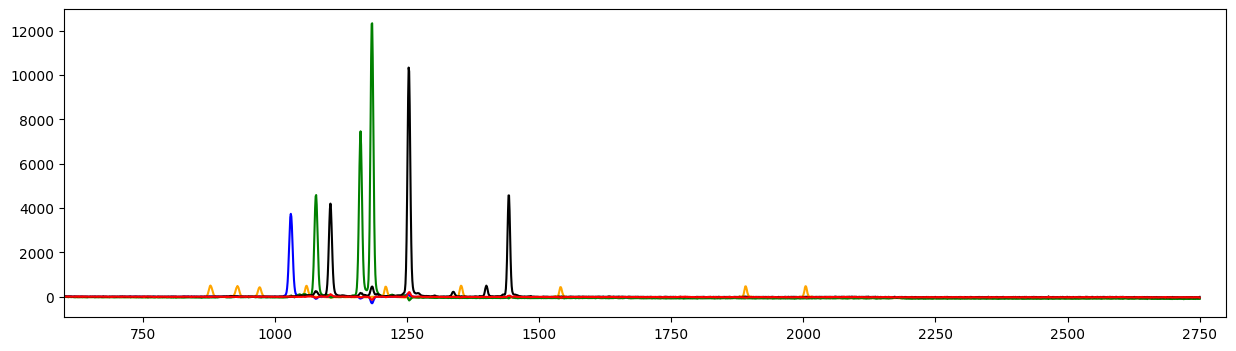

In [16]:
f = FSA('./raw_data/CYP2D6_DATA_20221006/FSA/20210622-630027_S2_CYP2D6_A09_01_SNaPshot50_POP7_E5.fsa')

plt.figure(figsize=(15,4))

for base in data_chanel_map:
    chanel = data_chanel_map.get(base)
    color = forward_color.get(base)
    plt.plot(f.extract_intensity(chanel), color=color)

plt.xlim(600,2800)
# plt.ylim(0,800)

peaks, heights = finding_peaks(f.reference_intensity, 9)

In [8]:
f = FSA('./raw_data/CYP2D6_DATA_20221006/FSA/20210622-630027_S1_CYP2D6_A06_01_SNaPshot50_POP7_E5.fsa')

# pre-setting
liz120 = [15, 20, 25, 35, 50, 62, 80, 110, 120]

ref = Reference(liz120)

import pandas as pd
peak_table = pd.read_excel('./resource/test_bin_peak.xlsx')
defined_markers = generate_markers(peak_table)


import pickle
with open('./resource/tables.pdata', 'rb') as t:
    tables = pickle.load(t)

definition = Definition(tables)

# fiding ref peaks
peaks, heights = finding_peaks(f.reference_intensity, 9, 300)

# buid models
m = LeastSquared(peaks, liz120)
# validation plot
# m.val_plot()

# prediction
pred = m.predict(range(f.chanel_size))

# extract index
min_index, max_index = get_index_by_base_range(pred, base_ranges=(0,200))

print(min_index, max_index)
select_base = pred[min_index:max_index]

fsa_panel = re.compile("S[0-9]|S[0-9]").search(f.name).group(0)

from copy import copy
markers = copy(defined_markers)

# call_markers = finding_peak_by_markers(markers, f, fsa_panel, select_base, (min_index, max_index))


738 2711


In [92]:

# height = [400, 500, 600, 700, 800]
height = [300]

from matplotlib.backends.backend_pdf import PdfPages

# pdf = PdfPages('reference_peak_detection.pdf')

ref_peak_df = pd.DataFrame()

for h in height:
    count = 0
    for _,row in samples.iterrows():
        fsa = FSA(row['path'])

        peaks, height = find_peaks(fsa.reference_intensity, height=h)

        if len(peaks) > 9:
            pro = peak_prominences(fsa.reference_intensity, peaks)[0]
            pro_sort = np.sort(pro)[::-1]
            m_pro = pro_sort[9]

            peaks, height = find_peaks(fsa.reference_intensity, height=h, prominence=m_pro+0.001)

        if len(peaks) > 9:
            diff = np.sort(np.diff(peaks))[::-1]
            # print(len(diff))
            m_dist = diff[8]
            peaks, height = find_peaks(fsa.reference_intensity, height=h, distance=m_dist+0.001)

        if len(peaks) == 9:
            count +=1
            # plt.figure(figsize=(15, 3))
            # plt.plot(fsa.reference_intensity, color ='orange', alpha=0.5)
            
            # for p,hi in zip(peaks, height['peak_heights']):
            #     plt.text(p, hi, 'x', ha='center')
            #     plt.title(fsa.name)

            # pdf.savefig()

            # tmp = pd.DataFrame({'sample': sample, })
            

    print(f'{str(h)}: {count}')
    
# pdf.close()

300: 200


In [46]:
fsa_files

['./validation/validate_data/FSA/M2000663_S1_PGx-NP_E01_05_SNaPshot50_POP7_E5.fsa',
 './validation/validate_data/FSA/M2000663_S2_PGx-NP_G01_07_SNaPshot50_POP7_E5.fsa']